In [1]:
from IPython.core.display import HTML
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [2]:
import numpy
#
import math
#
import scipy
from scipy import constants
#
import matplotlib.pyplot
%matplotlib inline
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
#
from JSAnimation.IPython_display import display_animation
# from JSAnimation import IPython_display
#
from moviepy.editor import *
# 
import timeit
import numba
from numba import jit
#
import sys
from sys import exit

In [3]:
def plot(v1, v2, xlabl, ylabl, title):
    ''' a function for plots
    
    Parameters
    ----------
    v1: x-axis vector
    v2: y-axis vector
    xlabl: label for x-axis values
    ylabl: label for y-axis values
    title: plot title
    
    Return:
    -------
    Plot!
    '''
    #
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    #
    pyplot.xlabel(xlabl, fontsize=18)
    pyplot.ylabel(ylabl, fontsize=18)
    #
    pyplot.tick_params(axis='x', pad=10)
    pyplot.tick_params(axis='y', pad=10)
    #
    pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
    #
    pyplot.title(title)
    pyplot.plot(v1,v2, color='k', ls='--', lw=2, marker='o');

In [4]:
def plot2(v1, v2, xlabl, ylabl, title, end_number):
    ''' a function for plots
    
    Parameters
    ----------
    v1: x-axis vector
    v2: y-axis vector
    xlabl: label for x-axis values
    ylabl: label for y-axis values
    title: plot title
    
    Return:
    -------
    Plot!
    '''
    #
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    #
    pyplot.xlabel(xlabl, fontsize=18)
    pyplot.ylabel(ylabl, fontsize=18)
    #
    pyplot.tick_params(axis='x', pad=10)
    pyplot.tick_params(axis='y', pad=10)
    #
    pyplot.xticks(numpy.arange(0, end_number+end_number/5, end_number/5))
    #
    pyplot.title(title)
    pyplot.plot(v1,v2, color='k', ls='--', lw=2, marker='o');

### Domain

In [5]:
def get_domain(Ld, n_gap):
    ''' This function obtains the domain based on a 
    staggered grid. The domain is divided into three parts:
    (1) anode region, (2) gap, (3) cathode.
    
    However the electrodes region is not modeled here and only the gap is considered
    with inlet boundary condition at the anode and an outlet boundary condition at the
    cathode
    
    Parameters:
    ----------
    Ld: Domain Length
    n_gap: number of boundary nodes in gap
    
    Returns:
    --------
    gap domain from x = 0 to x = length (this is the length of the interelectrode gap)
    '''
    #staggered grid approach
    #gap region
    xl_gap = 0.0
    xr_gap = Ld
    delx_gap = (xr_gap-xl_gap)/(n_gap-1.0)
    xb_gap = numpy.linspace(xl_gap, xr_gap, n_gap)
    xc_gap = xb_gap[:-1]+(delx_gap*0.5)
    #
    return delx_gap, xb_gap, xc_gap

In [6]:
# Domain, Dimensions
# L_chamber = 0.24  #meters
# L_cathode = 0.112
# L_anode = L_chamber - (Lgap + L_cathode)
Lgap = 0.004 #interelectrode gap [meters]
#
nx_gap = 121
#
#Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
Ran = 6.35/2. * 1./1000.  #anode radius [meters]
#
#get cell boundary and cell center locations
dx, xb, xc = get_domain(Lgap,nx_gap)
#
l2_target = 1e-7
#
#time step
dt = 1e-6 #{sec} time step

In [7]:
numpy.shape(xb)

(121,)

In [8]:
numpy.shape(xc)

(120,)

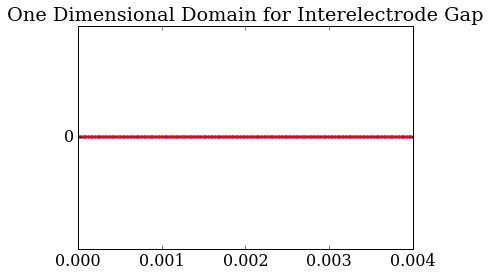

In [9]:
Xc_gap = numpy.meshgrid(xc)
Xb_gap = numpy.meshgrid(xb)
#
pyplot.title('One Dimensional Domain for Interelectrode Gap')
pyplot.ylim(-.0002,0.0002)
pyplot.xlim(0., Lgap)
pyplot.scatter(Xb_gap,numpy.zeros_like(Xb_gap),\
                   s=10, color='b', marker='o', linewidth=0)
pyplot.scatter(Xc_gap,numpy.zeros_like(Xc_gap), \
                   s=10, color='r', marker='o', linewidth=0)
pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
pyplot.yticks(numpy.arange(0, 0.0002, 0.001));

Note that velocities are calculated on the cell boundaries (blue), and the pressure, density,electrical conductivity, potential, current density and temperature are calculated on the cell center (red)

### Initialization

In [10]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence
    
    This function is used for convergence of the pressure equation

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    L2 norm of the error
    
    '''
    return numpy.sqrt(numpy.sum((p_new[:] - p_old[:])**2)\
                      /numpy.sum(p_old[:]**2))

In [11]:
#Input Current
I_arc = 60.0

#Initialization Variables
#gamma1 = 5.0/3.0
#gravity = 9.81

# collision radii, set equal to van der waal radii:
RSCD_N_B = (1.55 + 1.92) #nitrogen-boron
RSCD_N_Ni = (1.55 + 1.63) #nitrogen-nickel
RSCD_N_Co = (1.55 + 1.63) #nitrogen-cobalt, note that cobalt radius not available 

#Constants
Ckb = scipy.constants.k  #Boltzmann Constant J/K
Cme = scipy.constants.m_e #Elementary Electron Mass kg
Ch = scipy.constants.h; # Planck's constant Js
CA = 1.2e6 #Richardson constant in electron current density eqn [A/(m^2 K^2)], pg.62
CNA = scipy.constants.N_A #avogadros number
Ce = scipy.constants.e #elementary charge, C

#Boron
rho_B = 2460. #kg/m3
M_B = 10.811e-3/CNA #kg, mass of 1 atom of pure boron (also = Ckb/M)
mB = 10.811 # molar mass g/mol
Ips1 = 800.6e3/CNA #J, energy of first ionization
cp_B = 1030. # J/(Kg K)
R_B = 8314.0/mB #specific gas constant
Boron_workfunction = 4.45 #eV
dH_B = (507/mB)*1e6 #heat of vaporization J/Kg
Uiz_B = 8.2980 #eV
k_B = 27. #W/(mK)

#Nickel
rho_Ni = 8908
M_Ni = 58.6934e-3/CNA #kg, mass of 1 atom of pure nickel (also = Ckb/M)
mNi = 58.6934 # molar mass g/mol
Ips2 = 737.1e3/CNA #J, energy of first ionization
cp_Ni = 445. # J/(Kg K)
R_Ni = 8314.0/mNi #specific gas constant
Nickel_workfunction = 5.01 #eV
dH_Ni = (378/mNi)*1e6 #heat of vaporization J/Kg
Uiz_Ni = 7.6398 #eV
k_Ni = 91. #W/(m K)

#Cobalt
rho_Co = 8900.
M_Co = 58.9332/CNA #kg, mass of 1 atom of pure cobalt (also = Ckb/M)
mCo = 58.9332 # molar mass g/mol
Ips3 = 760.4e3/CNA #J, energy of first ionization
cp_Co = 418.68# J/(Kg K)
R_Co = 8314.0/mCo #specific gas constant
Cobalt_workfunction = 5.0 #eV
dH_Co = (375/mCo)*1e6 #heat of vaporization J/Kg
Uiz_Co = 7.8810 #eV
k_Co = 100. #W/(m K)

#Nitrogen gas
rho_N = 1.25
M_N = (2*14.0067)/CNA # kg, mass of 1 atom of Helium
mN = (2*14.0067) #molar mass, g/mol
Ipg1 = 1402.3e3/CNA; # J, energy of first ionization
R_N = 8314.0/mN #specific gas constant
cp_N = 1039. #J/Kg-K
Uiz_N = 14.5341 #eV
k_N = 0.02583 #W/(m K)

In [12]:
#composition of ingot (grams)
WB = 2.00
WNi = 0.5*(WB*(1-0.99))/0.99
WCo = 0.5*(WB*(1-0.99))/0.99
Wtotal = WB+WNi+WCo

#mass fractions
wB = WB/(Wtotal)
wNi = WNi/(Wtotal)
wCo = WCo/(Wtotal)

#molar fractions
xtotal = WB/mB + WNi/mNi + WCo/mCo
xB = (WB/mB)/xtotal
xNi = (WNi/mNi)/xtotal
xCo = (WCo/mCo)/xtotal
xN = 0.

#molecular weight of evaporated anode material
MW_evap = 1/((wB/mB)+(wNi/mNi)+(wCo/mCo))

rho_an_max = 0.99*(rho_B) + 0.005*(rho_Ni+rho_Co)
Rs_an = 0.99*(R_B) + 0.005*(R_Ni+R_Co)
M_an = 0.99*M_B  + 0.005*(M_Ni + M_Co)
k_an = 0.99*k_B  + 0.005*(k_Ni + k_Co)
cp_an = 0.99*cp_B  + 0.005*(cp_Ni + cp_Co)
Uiz_an = 0.99*Uiz_B  + 0.005*(Uiz_Ni + Uiz_Co)
dH_an = 0.99*dH_B  + 0.005*(dH_Ni + dH_Co)
anode_workfunction = 0.99*Boron_workfunction +\
                    0.005*(Nickel_workfunction+Cobalt_workfunction) #anode material

##### Initial Conditions

In [13]:
def get_initial_conditions(x1,x2,I_input,R_anode):
    '''
    - Defines initial arrays
    - Adds two ghost cells to represent nodes on anode and cathode,
        for boundary conditions
    
    Parameters:
    -----------
    x1: boundary x locations
    x2: center cell x locations
    I_input: arc current input
    R_anode: anode radius
    
    Returns:
    -------
    Arrays!
    Tx: temperature 
    jx: current density
    phix: electric potential
    cpx: specific heat
    visc: viscosity (mu)
    ux: velocity
    kx: thermal conductivity
    rhox: density
    Px: pressure
    hx: enthalpy
    econdx: electrical conductivity
    nex: number density of electrons
    
    Consistent with the staggered grid approach, the velocity is calculated on the
    cell boundaries and all of the other values are computed on the cell centers.
    '''
    Tref = 300.0 # initial reference temperature
    #
    a = numpy.size(x1) + 2 #this is to add ghost cells, these are boundary cells
    b = numpy.size(x2) + 2 #this is to add ghost cells, these are center cells
    #-------------------------------------------------------------------------
    #initialize arrays
    #grid 1 (cell edges)
    ux = numpy.zeros((a),dtype=float) #velocity
    #grid 2 cell centers-----------------------
    jx = numpy.zeros((b), dtype=float) #current density
    phix = numpy.zeros((b),dtype=float) #electric potential
    econdx = numpy.zeros((b),dtype=float) #electrical conductivity
    rhox = numpy.zeros((b),dtype=float) #density
    nex = numpy.zeros((b), dtype=float) #number density of electrons
    #
    cpx = numpy.zeros((b),dtype=float) #specific heat
    Tx = numpy.zeros((b),dtype=float) #temperature
    visc = numpy.zeros((b),dtype=float) #viscosity
    kx = numpy.zeros((b),dtype=float) #thermal conductivity
    Px = numpy.zeros((b),dtype=float) # pressure
    hx = numpy.zeros((b),dtype=float) #enthalpy
    Rs = numpy.zeros((b),dtype=float) # specific gas constant
    #-------------------------------------------------------------------------
    jx[:] = I_input/(numpy.pi*(R_anode**2)) #current density 
    # electric potential
    phix[:] = 0.0
    # specific heat
    cpx[1:] = cp_N #J/(kg-K) of helium
    cpx[0] = cp_an
    # temperature
    Tx[:] = Tref #kelvin # assume uniform temperature
    #enthalpy
    hx[:] = cpx[:]*Tx[:]
    # viscosity
    visc[:] = 1.76e-6 #of Nitrogen Pa·s = kg/(s·m)
    # velocity, assume still
    ux[:] = 0. # m/s
    # thermal conductivity
    kx[1:] = 0.02583  # W/(m-K)
    kx[0] = k_an
    # electrical conductivity
    econdx[:] = I_input # Siemens/meter
    # number density of electrons
    nex[:] = 1e6 # 1/m3, number density of electrons
    # density
    rhox[0] = rho_N #nitrogen, this is anode material but set as nitrogen to start
    rhox[1:] = rho_N #nitrogen
    #
    Px[:] = (rhox[:])*R_N*Tx[:] + (nex[:])*Ckb*Tx[:] #50662.5 #
    #
    return Tx, jx, phix, cpx,visc, ux, kx, rhox, Px, hx, econdx, nex

In [14]:
T0,j0,phi0,cp0,mu0,u0,\
k0,rho0,p0,h0,econd0,ne0 = get_initial_conditions(xb,xc,I_arc,Ran)

##### reference values

In [15]:
# reference values are stored (n-1) time step,
# because they are used in the energy equation 
pref = p0.copy() 
Tref = T0.copy()
rhoref = rho0.copy()
nexnref = ne0.copy()
uxnref = u0.copy()
jn = j0.copy()
#
numx = numpy.size(p0) #number of center nodes with ghost cells

##### potential algorithm

In [16]:
def get_electric_potential(current_density,electrical_conductivity,\
                           electric_potential, center_nodes, delx):
    ''' Defines the electric potential field.
    
    This function obtains the electric potential based on two solutions to the 
    ordinary differential equation.
    
    Solution 1: B^2 - 4AC = 0
    Solution 2: B^2 - 4AC > 0
    
    Parameters
    ----------
    current_density: current density in the domain, constant current is assumed
    electrical_conductivity: 
    electric_potential: electric potential is solved from d/dx{-econd d/dx(phi)} =0
    center_nodes: cell-center nodes are used to solve electric potential
    delx: x-direction spacing
    
    Returns:
    --------
    electric potential
    '''
    jx = current_density.copy()
    #
    xc_nodes = center_nodes.copy()
    x_an = xc_nodes[0] - 0.5*delx
    x_cath = xc_nodes[-1] + 0.5*delx
    #
    array_size = electrical_conductivity.size
    eratio = numpy.zeros_like(center_nodes)
    #
    A = numpy.zeros_like(electrical_conductivity)
    B = numpy.zeros_like(electrical_conductivity)
    #
    C1 = numpy.zeros_like(electrical_conductivity)
    C2 = numpy.zeros_like(electrical_conductivity)
    #
    econdx = electrical_conductivity.copy()
    phix = electric_potential.copy()
    #
    jx_anode = I_arc/(numpy.pi*(Ran**2)) 
    econdx_anode = 1e5 #electrical conductivity max
    anode_potential = jx_anode*delx/econdx_anode
    #
    cathode_potential =  -1.
    #
    A[1:-1] =  - econdx[1:-1]
    B[1:-1] = - (0.5/delx)*(econdx[2:] - econdx[:-2])
    #
    for i in range(1,array_size-1):
        if (B[i]**2 == 0.0 ):
            # general solution constants
            C2[i] = (cathode_potential/(numpy.exp((-B[i]/A[i])*x_cath)) -\
                     anode_potential)/(x_cath-x_an)
            C1[i] = (anode_potential/(numpy.exp((-B[i]/A[i])*x_an))) -\
                     anode_potential
            # potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) +\
                      C2[i]*xc_nodes[i-1]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1])
        if (B[i]**2 > 0.0):
            #print('using {B**2 > 0} solution for potential')
            eratio[:] = numpy.exp((-B[i]/A[i])*x_cath)/numpy.exp((-B[i]/A[i])*x_an)
            C2[i] = (cathode_potential-anode_potential*eratio[i-1])/(1.-eratio[i-1])
            C1[i] = (anode_potential-C2[i])/numpy.exp((-B[i]/A[i])*x_an)
            #potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) + C2[i]
    #
    phix[0] = jx_anode*delx/econdx_anode
    phix[-1] = cathode_potential
    #
    return phix

In [17]:
phin = get_electric_potential(j0.copy(),econd0.copy(), phi0.copy(), xc.copy(), dx)

##### Ablation of Anode

In [18]:
def get_anode_temperature(anode_temperature):
    ''' computes the anode temperature 
    '''
    Tan = anode_temperature
    return Tan

In [19]:
Tanode = get_anode_temperature(T0[0])
Tanode

300.0

In [20]:
def get_saturation_pressure(anode_temperature, molecular_weight_anode,\
                        molar_fraction_s1, molar_fraction_s2, molar_fraction_s3):
    ''' Defines saturation pressure at anode based on curves
    
    s1: Boron
    s2: Nickel
    s3: Cobalt
    
    Returns:
    --------
    Psat: Total saturation pressure [Pa]
    '''
    Tan = anode_temperature
    Man = molecular_weight_anode
    # Boron saturation pressure (using carbon curves for now)
    xs1 = molar_fraction_s1
    A_s1 = 15.73
    B_s1 = 40030.0
    psat_s1 = (0.133*numpy.exp(2.3*(A_s1 - B_s1/Tan)))
    # Nickel saturation pressure
    xs2 = molar_fraction_s2
    A_s2 = 12.75
    B_s2 = 20960.0
    psat_s2 = (0.133*numpy.exp(2.3*(A_s2 - B_s2/Tan)))
    # Cobalt saturation pressure (use nickel for now)
    xs3 = molar_fraction_s3
    A_s3 = 12.75
    B_s3 = 20960.0
    psat_s3 = (0.133*numpy.exp(2.3*(A_s3 - B_s3/Tan)))
    #total saturation pressure
    psat = xs1*psat_s1 + xs2*psat_s2 + xs3*psat_s3
    #
    return psat
    

In [21]:
Psaturation = get_saturation_pressure(Tanode, MW_evap, xB, xNi, xCo)
Psaturation

2.1840404215416084e-61

In [22]:
def get_ablation_rate(anode_temperature, saturation_pressure,\
                      molecular_weight_anode):
    '''Defines ablation rate in { kg } / { m2 s }
    
    Parameters:
    -----------
    anode temperature
    molecular weight of anode material
    total saturation pressure 
    
    Returns:
    --------
    mass flux of evaporated material
    '''
    #
    Ru = 8134.
    abl_rate = saturation_pressure*\
                numpy.sqrt(molecular_weight_anode/(2*numpy.pi*Ru*anode_temperature))
    #
    return abl_rate

In [23]:
ablrate = get_ablation_rate(Tanode,Psaturation,MW_evap)
ablrate

1.8414950049224023e-64

In [24]:
def get_velocity_of_evaporated_mass(anode_temperature, molecular_weight_anode):
    ''' Defines velocity of evaporated mass using thermal velocity
    
    Returns:
    --------
    thermal velocity of evaporated mass [m/s]
    '''
    Ru = 8134.
    vth_evap = 0.5*numpy.sqrt((8*Ru*anode_temperature)/\
                              (molecular_weight_anode*numpy.pi))
    return vth_evap

In [25]:
velocity_evap = get_velocity_of_evaporated_mass(Tanode, MW_evap)
velocity_evap

377.52025182984534

In [26]:
def get_density_of_evaporated_mass(ablation_rate, velocity_evaporated_mass):
    ''' Calculates the density of evaporated material 
    
    Returns:
    --------
    Density of evaporated material [kg/m3]
    '''
    density_evap = ablation_rate/velocity_evaporated_mass
    return density_evap

In [27]:
rho_evap = get_density_of_evaporated_mass(ablrate,velocity_evap)
rho_evap

4.8778707791082817e-67

##### Initial Species Concentrations

In [28]:
def get_initial_concentrations(density,ablated_density, mass_fraction_s1,\
                              mass_fraction_s2, mass_fraction_s3):
    ''' defines initial concentrations for individual species in the domain
    
    Parameters:
    -----------
    density: total density in the domain
    ablated_density: vapor density obtained from vapor pressure
    
    Returns:
    -------
    cs1: concentration of boron species
    cs2: concentration of nickel species
    cs3: concentration of cobalt species
    cg1: concentration of nitrogen species
    '''
    rhox = density.copy()
    #
    cs1 = numpy.zeros_like(density)
    cs2 = numpy.zeros_like(density)
    cs3 = numpy.zeros_like(density)
    cg1 = numpy.zeros_like(density)
    #
    xs1 = mass_fraction_s1
    xs2 = mass_fraction_s2
    xs3 = mass_fraction_s3
    #Concentration of boron
    cs1[1:] = 1e-14
    cs1[0] =  (xs1*ablated_density + cs1[1]*rhox[1])/(ablated_density+rhox[1])
    #nickel
    cs2[1:] = 1e-14
    cs2[0] = (xs2*ablated_density + cs2[1]*rhox[1])/(ablated_density+rhox[1])
    #cobalt
    cs3[1:] = 1e-14
    cs3[0] = (xs3*ablated_density + cs3[1]*rhox[1])/(ablated_density+rhox[1])
    # nitrogen
    cg1[:] = 1.-cs1[:]-cs2[:]-cs3[:]
    #
    return cs1, cs2, cs3, cg1

In [29]:
cB,cNi,cCo,cN = get_initial_concentrations(rho0.copy(),rho_evap,xB,xNi,xCo)

##### Thermophysical Properties:  thermal conductivity, shear viscosity, and specific heat

In [30]:
def get_thermophysical_properties(temperature,concentration1,concentration2,\
                                 concentration3,concentration4):
    '''finds viscosity, thermal conductivity
    
    Parameters:
    -----------
    mu: viscosity
    kth: thermal conductivity
    '''
    cs1 = concentration4 #nitrogen
    cs2 = concentration2 #boron
    cs3 = concentration3 #nickel
    cs4 = concentration1 #cobalt
    #
    mu = numpy.zeros_like(temperature) #viscosity
    mus1 = numpy.zeros_like(temperature)
    mus2 = numpy.zeros_like(temperature)
    mus3 = numpy.zeros_like(temperature)
    mus4 = numpy.zeros_like(temperature) 
    #
    kth = numpy.zeros_like(temperature) #thermal conductivity
    ks1 = numpy.zeros_like(temperature) #thermal conductivity s1
    ks2 = numpy.zeros_like(temperature) #thermal conductivity s2
    ks3 = numpy.zeros_like(temperature) #thermal conductivity s3
    ks4 = numpy.zeros_like(temperature) #thermal conductivity s4
    #
    Tx = temperature.copy() # temperature
    a = numpy.size(Tx)
    #
    #--------thermal conductivity---------
    #conductivity of Nitrogen
    aN4,bN4 = 1.1973364764750705e-11,-1.0022238377799794e-07 
    cN4,dN4,eN4 = 0.00025655111953739039,-0.1423732005907308,33.464978104210182
    ks1[:] = 1e-3*(aN4*(Tx[:]**4) + bN4*(Tx[:]**3) +\
                   cN4*(Tx[:]**2) + dN4*Tx[:] + eN4)
    #conductivity of Boron
    ks2[:] = k_B
    #conductivity of Nickel
    ks3[:] = k_Ni
    #conductivity of Cobalt
    ks4[:] = k_Co
    # total viscosity
    kth[:] = cs1[:]*ks1[:] + cs2[:]*ks2[:] + cs3[:]*ks3[:] + cs4[:]*ks4[:] 
    kth[-1] = kth[-2]#2*kth[-2] - kth[-3]
    #
    #--------dynamic viscosity------------------
    #viscosity of nitrogen
    aNmu,bNmu = 4.2177299011972125e-09, -4.8160156609647342e-05
    cNmu,dNmu = 0.40073205811284623, 44.208627576799387
    mus1[:] = 1e-7*(aNmu*(Tx[:]**3) + bNmu*(Tx[:]**2) + cNmu*(Tx[:]) + dNmu)
    #viscosity of boron (gas)
    mus2[:] = 5.4e-5 #viscosity used in carbon-helium simulation #1e-5 #2e-3
    #viscosity of nickel (gas)
    mus3[:] = 0.
    #viscosity of viscosity (gas)
    mus4[:] = 0.
    #total viscosity
    mu[:] = cs1[:]*mus1[:] + cs2[:]*mus2[:] + cs3[:]*mus3[:] + cs4[:]*mus4[:]
    mu[-1] = mu[-2]#2*mu[-2] - mu[-3]
    #
    return kth,mu

In [31]:
# thermal conductivity and viscosity:
kn, mun = get_thermophysical_properties(T0.copy(),cB.copy(),cNi.copy(),\
                                        cCo.copy(),cN.copy())

In [32]:
knref = kn.copy() 
munref = mun.copy()

In [33]:
kn[:10]

array([ 0.0112336,  0.0112336,  0.0112336,  0.0112336,  0.0112336,
        0.0112336,  0.0112336,  0.0112336,  0.0112336,  0.0112336])

In [34]:
mun[:10]

array([  1.60207710e-05,   1.60207710e-05,   1.60207710e-05,
         1.60207710e-05,   1.60207710e-05,   1.60207710e-05,
         1.60207710e-05,   1.60207710e-05,   1.60207710e-05,
         1.60207710e-05])

In [35]:
def get_specific_heat(temperature,concentration1,concentration2,concentration3,\
                      concentration4):
    '''
    
    old values used:
    #     cp_s1[:] = 1030.
    #     cp_s2[:] = 725.0
    #     cp_s3[:] = 421.
    #     cp_g1[:] = 1040.
    
    This if for BN  
    #cp_total[:] = 3.46 + (7.24e-3)*Tx[:] # this is for Boron Nitride
    
    ref:thermodynamic properties of 65 elements
    '''
    Tx = temperature.copy()
    #
    cp_s1 = numpy.zeros_like(temperature) #boron
    cp_s2 = numpy.zeros_like(temperature) #nickel
    cp_s3 = numpy.zeros_like(temperature) #cobalt
    cp_g1 = numpy.zeros_like(temperature) #nitrogen
    #
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    c3 = concentration3.copy()
    cg1 = concentration4.copy()
    #
    array_size = numpy.size(temperature)
    cp_total = numpy.zeros_like(temperature)
    #
    #specific heat of nitrogen gas
    for i in range(array_size):
        cp_g1[i] = 6.66 + 1.02*(1e-3)*Tx[i] # {cal}/{gram-mole K}
    #conversion:
    mw_N2 = 2*14.0067*(1e-3) # molar mass in kg
    cp_g1[:] = cp_g1[:] * (4.184)/mw_N2
    #---------------------------------------------
    #specific heat of Boron
    for i in range(array_size):
        if (Tx[i] < 1200.):
            cp_s1[i] = 1.54 + 4.49*(1e-3)*Tx[i]
        else:
            cp_s1[i] = 1.54 + 4.49*(1e-3)*1200.
    #conversion
    mw_B = 10.811*1e-3 #kg
    cp_s1[:] = cp_s1[:] * 4.814/mw_B
    #---------------------------------------------
    # specific heat of nickel
    for i in range(array_size):
        if ( Tx[i] < 633.0):
            cp_s2[i] = 4.06 + 7.04*(1e-3)*Tx[i]
        elif (Tx[i] >= 633. and Tx[i] < 1725.):
        #elif (633. <= Tx[i] < 1725.) :
            cp_s2[i] = 6.0 + 1.8*(1e-3)*Tx[i]
        elif (Tx[i] >=1725):
            cp_s2[i] = 9.20
    #conversion
    mw_Ni = 58.6934*1e-3
    cp_s3[:] = cp_s3[:] * (4.184)/mw_Ni
    #
    #specific heat of cobalt
    for i in range (array_size):
        if (Tx[i] < 718.):
            cp_s3[i] = 4.72 + 4.3*(1e-3)*Tx[i]
        elif ( Tx[i] >= 718. and  Tx[i] < 1400.):
            cp_s3[i] = 3.30 + 5.86*(1e-3)*Tx[i]
        elif (Tx[i] >= 1400.):
            cp_s3[i] = 9.60
    #conversion:
    mw_Co = 58.933195*1e-3
    cp_s3[:] = cp_s3[:] * 4.184/mw_Co
    #
    #total specific heat
    cp_total[:] = c1[:]*cp_s1[:] + c2[:]*cp_s2[:] + c3[:]*cp_s3[:] +\
                  cg1[:]*cp_g1[:]
    cp_total[-1] = cp_total[-2]
    #
    return cp_total

In [36]:
cpn = get_specific_heat(T0.copy(),cB,cNi,cCo,cN)

In [37]:
cpnref = cpn.copy()

In [38]:
cpn[:10]

array([ 1040.42151256,  1040.42151256,  1040.42151256,  1040.42151256,
        1040.42151256,  1040.42151256,  1040.42151256,  1040.42151256,
        1040.42151256,  1040.42151256])

In [39]:
def get_molecular_weight_domain(molar_mass_s1, molar_mass_s2, molar_mass_s3,\
                               molar_mass_g1, concentration_s1, concentration_s2,\
                               concentration_s3, concentration_g1):
    ''' Defines the molecular weight g/mol in domain
    
    s1: Boron
    s2: Nickel
    s3: Cobalt
    g1: Nitrogen
    '''
    #molar mass
    ms1 = molar_mass_s1
    ms2 = molar_mass_s2
    ms3 = molar_mass_s3
    mg1 = molar_mass_g1
    #concentrations
    cs1 = concentration_s1
    cs2 = concentration_s2
    cs3 = concentration_s3
    cg1 = concentration_g1
    #
    MWdomain = numpy.zeros_like(concentration_s1)
    #
    MWdomain[:] = 1./((cs1[:]/ms1) + (cs2[:]/ms2) + (cs3[:]/ms3) + (cg1[:]/mg1))
    #
    return MWdomain

In [40]:
MWn = get_molecular_weight_domain(mB,mNi,mCo,mN,cB,cNi,cCo,cN)
MWn[:10]

array([ 28.0134,  28.0134,  28.0134,  28.0134,  28.0134,  28.0134,
        28.0134,  28.0134,  28.0134,  28.0134])

In [41]:
def get_gas_constant_domain(molecular_weight_domain):
    ''' defines specific gas constant in domain from molecular weight
    
    molecular weight: array of values [g/mol]
    '''
    MWdomain = molecular_weight_domain.copy()
    Ru = 8134.
    Rsdomain = numpy.zeros_like(molecular_weight_domain)
    Rsdomain[:] = Ru/MWdomain[:]
    #
    return Rsdomain

In [42]:
Rsn = get_gas_constant_domain(MWn)
Rsn[:10]

array([ 290.3610415,  290.3610415,  290.3610415,  290.3610415,
        290.3610415,  290.3610415,  290.3610415,  290.3610415,
        290.3610415,  290.3610415])

##### Obtain mass-averaged velocity for anode boundary condition

In [43]:
def get_ablation_velocity(ablation_rate, ablated_density,local_anode_density):
    '''obtains the velocity of sublimated particles, these will be used as boundary
    conditions, considered mass-averaged velocity
    
    Parameters:
    ----------
    ablation rate in kg/{m2 s}
    local anode density
    ablated density (vapor density obtained from vapor pressure)
    
    Returns:
    --------
    velocity of sublimated particles {m/s}
    '''
    ablation_velocity = (ablation_rate)/(local_anode_density+ablated_density)
    #
    return ablation_velocity

In [44]:
uabl = get_ablation_velocity(ablrate,rho_evap,rho0[1])

In [45]:
uabl #m/s

1.4731960039379218e-64

In [46]:
def get_initial_velocity(velocity, ablation_velocity):
    ''' defines initial velocity in the field
    
    Boundary_conditions:
    --------------------
    Ghost cell and anode/fluid interface velocities are set equal to the
    sublimation velocity
    
    Parameters:
    -----------
    velocity in the field {m/s}
    ablation velocity of anode material {m/s}
    
    Returns:
    --------
    velocity with updated sublimation velocity
    
    '''
    ui = velocity.copy()
    #anode region
    ui[1] = ablation_velocity
    ui[0] = ablation_velocity
    # cathode region
    ui[-2] = 2*ui[-3] - ui[-4]
    ui[-1] = 2*ui[-2] - ui[-3]
    #
    return ui

In [47]:
def get_velocity_bc(velocity, ablation_velocity):
    ''' updates the velocity boundary conditions
    
    anode bc: dirichlet set to ablation velocity
    cathode bc: homogeneous dirichlet
    
    Parameters:
    -----------
    velocity: total (divergence-free) velocity
    ablation_velocity: velocity of sublimated particles
    
    Returns:
    ---------
    ubc: updated velocity boundary conditions
    '''
    ubc = velocity.copy()
    #
    ubc[1] = ablation_velocity
    ubc[0] = ablation_velocity
    #
    ubc[-2] = 2*ubc[-3] - ubc[-4]
    ubc[-1] = 2*ubc[-2] - ubc[-3]
    #
    return ubc

In [48]:
uxn = get_initial_velocity(uxnref.copy(),uabl)

In [49]:
uxn = get_velocity_bc(uxn.copy(),uabl)
uxn[:10]

array([  1.47319600e-64,   1.47319600e-64,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

##### update density boundary conditions to incude ablated density

In [50]:
def get_density_bc(density, ablated_density):
    ''' updates densities in the anode region 
        by summing ablated density with local density
    
    Parameters:
    -----------
    density: total density in the domain
    ablated_density: vapor density obtained from vapor pressure
    
    Returns:
    -------
    density with updated boundary values
        
    '''
    #
    rhobc = density.copy()
    local_anode_density = rhobc[1]
    #anode region
    rhobc[0] = ablated_density + local_anode_density
    #
    return rhobc

##### mass conservation to find $\rho^{n+1}$

In [51]:
def get_mass_conservation(density, velocity, delx, delt):
    ''' solves mass conservation to obtain total density in the field
    
    Parameters:
    -----------
    density: current density distribution
    velocity: current velocity distribution
    delx: x-direction spacing
    delt: time step
    
    Returns:
    --------
    rho_new: new total density distribution
    
    '''
    # densities
    rhox = density.copy()
    rho_new = density.copy()
    #velocity
    ux = velocity.copy()
    ux_int = numpy.zeros_like(density)
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    #
    # mass conservation
    rho_new[1:-1] = rhox[1:-1] - (0.5*delt/delx)*\
                                    (rhox[2:]*ux_int[2:] - rhox[:-2]*ux_int[:-2])
    #boundary conditions
    rho_new[0] = rhox[0]
    rho_new[-1] = 2*rho_new[-2] - rho_new[-3]
    #
    return rho_new

In [52]:
rhoxn = get_density_bc(rhoref.copy(),rho_evap)
rhoxn = get_mass_conservation(rhoxn, uxn, dx, dt)
rhoxn[:10]


array([ 1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25])

##### this new density will not be used to update the fluxes in the momentum equation but will be used at the last step to solve for $u^{n+1}$

\begin{align}
(\rho u )^{n+1} &= f(\rho^{n},u^{n},P^{n},\mu^{n}) \nonumber \\
(u)^{n+1} &= \frac{f(\rho^{n},u^{n},P^{n},\mu^{n})}{\rho^{n+1}} \nonumber
\end{align}

### Now solve momentum equation to find $u^{n+1}$ and $P^{n+1}$

In [53]:
def get_interpolated_density(velocity,density):
    '''
    '''
    rhox = density.copy()
    rhoxint = numpy.zeros_like(velocity)
    #ghost cell anode:
    rhoxint[0] = rhox[0]
    rhoxint[1] = rhox[0]
    #interior points:
    rhoxint[2:-2] = 0.5*(rhox[2:-1]+rhox[1:-2])
    #ghost cell cathode:
    rhoxint[-2] = 0.5*(rhox[-1]+rhox[-2])
    rhoxint[-1] = 2*rhoxint[-2] - rhoxint[-3]
    #
    return rhoxint

In [54]:
rhoxn_int = get_interpolated_density(uxn,rhoxn)
rhoxn_int[:5]

array([ 1.25,  1.25,  1.25,  1.25,  1.25])

In [55]:
def get_current_momentum(density,velocity):
    ''' This function obtains momentum at nth time step
    
    Parameters:
    -----------
    density @ nth time step
    velocty @ nth time step
    
    Returns:
    --------
    momentum = density*velocity 
    '''
    #arrays
    momx = numpy.zeros_like(velocity)
    rhox = density.copy()
    ux = velocity.copy()
    rhoxint = get_interpolated_density(ux,rhox)
    # momentum
    momx[:] = ux[:]*rhoxint[:]
    #
    return momx
    

In [56]:
def get_momentum_bc(momentum,ablated_velocity,density_anode):
    ''' Boundary Conditions for current momentum (nth time step)
    
    Parameters:
    -----------
    density_anode: total density at rho[0]
    '''
    mombc = momentum.copy()
    #
    mombc[0] = ablated_velocity*density_anode
    mombc[1] = ablated_velocity*density_anode
    # 
    mombc[-2] = 2*mombc[-3] - mombc[-4]
    mombc[-1] = 2*mombc[-2] - mombc[-3]
    #
    return mombc

In [57]:
momn = get_current_momentum(rhoxn.copy(),uxn.copy())
momn[:5]

array([  1.84149500e-64,   1.84149500e-64,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [58]:
momn = get_momentum_bc(momn,uabl,rhoxn[0] )
momn[:5]

array([  1.84149500e-64,   1.84149500e-64,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [59]:
def get_convective_flux(velocity,density,delx):
    ''' calculates convective fluxes for momentum equation
        uses central differencing scheme 
        
    Parameters:
    -----------
    velocity: helmholtz velocity
    delx: x-direction spacing
    
    Returns:
    -------
    fc: convective fluxes
    '''
    ux = velocity.copy()
    rhoxint = get_interpolated_density(velocity,density)
    fc = numpy.zeros_like(velocity)
    #
    #
    fc[1:-1] = (-0.5/delx)*((rhoxint[2:]*ux[2:]**2) -\
                            (rhoxint[:-2]*ux[:-2]**2) )
    #
    return fc

In [60]:
fct = get_convective_flux(uxn,rhoxn,dx)
fct[:5]

array([  0.00000000e+000,   4.06932462e-124,   4.06932462e-124,
        -0.00000000e+000,  -0.00000000e+000])

In [61]:
def get_viscous_flux(velocity,shear_viscosity,delx):
    ''' calculates viscous fluxes for momentum equation
        uses central differencing scheme
        
    Parameters:
    -----------
    velocity: helmholtz velocity
    delx: x-direction spacing
    shear_viscosity: mu
    density: total density in domain
    
    Returns:
    --------
    fv: viscous fluxes
    '''
    ux = velocity.copy()
    fv = numpy.zeros_like(velocity)
    #
    mux = shear_viscosity.copy()
    muxb = numpy.zeros_like(velocity) #interpolated viscosity boundary values
    muxb[1:-1] = 0.5*(mux[1:]+mux[:-1])
    #
    fv[1:-1] = (muxb[1:-1])*(1/(delx**2))*(ux[2:] - 2*ux[1:-1] + ux[:-2])
    #
    return fv

In [62]:
fvt= get_viscous_flux(uxn.copy(),mun.copy(),dx)
fvt[:5]

array([  0.00000000e+00,  -2.12415622e-60,   2.12415622e-60,
         0.00000000e+00,   0.00000000e+00])

In [63]:
def get_pressure_flux(velocity, pressure, delx):
    ''' calculates pressure fluxes for momentum equation
    
    Parameters:
    ----------
    velocity: helmholtz velocity
    pressure: heavy particle pressure only, exclude electron pressure
    delx: x-direction spacing
    
    Returns:
    -------
    fp: pressure flux
    '''
    px = pressure.copy()
    #
    fp = numpy.zeros_like(velocity)
    #
    fp[1:-1] = -(1./delx)*(px[1:]-px[:-1])
    #
    return fp

In [64]:
fpt = get_pressure_flux(uxn.copy(), pref.copy(), dx)
fpt[:5]

array([ 0., -0., -0., -0., -0.])

In [65]:
def get_source_pressure(density_new, density_old, momentum, delx, delt):
    ''' computes the pressure source terms
    
    Parameters:
    -----------
    velocity: helmholtz velocity
    pressure: heavy particle pressure
    delx: x-direction spacing
    
    Returns:
    --------
    fps: pressure source term
    '''
    rho_new = density_new.copy()
    rho_old = density_old.copy() 
    momx = momentum.copy()
    fps = numpy.zeros_like(density_old)
    #
    fps[:] = (1./delx)*(momx[1:] - momx[:-1]) +\
             (1./delt)*(rho_new[:]-rho_old[:])
    #
    return fps

In [66]:
fs = get_source_pressure(rhoxn.copy(),rhoref.copy(),momn.copy(),dx,dt)
fs[:5]

array([  0.00000000e+00,  -5.52448501e-60,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [67]:
@jit(nopython=True)
def get_pressure_GS(p,pk,delx,delt,l2_target,factor,fsp,numx,\
                   local_molecular_weight, evap_molecular_weight,\
                   density_anode, temperature_anode, density_evaporated):
    ''' Uses Gauss_Sidel to solve for pressure
    
    Parameters:
    -----------
    p: pressure {time n}
    pk: pressure {time n-1}
    delx: x-direction spacing
    delt: time step
    l2_target: target error value
    factor: used for the fractional step method
    fsp: pressure source term
    numx: number of nodes
    '''
    weight1 = density_evaporated/(density_anode+density_evaporated)
    weight2 = numpy.abs(1.-weight1)
    #
    Rgas_anode = 8314./(weight2*local_molecular_weight+\
                        weight1*evap_molecular_weight)
    #
    Pan = density_anode*Rgas_anode*temperature_anode
    #
    iterations = 0
    iter_diff = l2_target + 1.1
    denominator = 0.0
    l2_err = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for i in range(numx):
            pk[i] = p[i] 
        #        
        iter_diff = 0.0
        denominator = 0.0
        #
        for i in range(1,numx-1):
            p[i] = 0.5*(p[i+1]+p[i-1])-(0.5*(delx**2)*(1/(delt*factor))*fsp[i])
            #
        #boundary conditions
        p[0] = Pan
        p[-1] = 2*p[-2] - p[-3]
        #
        for i in range(1,numx-1):
            iter_diff += (p[i] - pk[i])**2
            denominator += (pk[i]*pk[i])
        #
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_err[iterations] = iter_diff
        iterations += 1    
        
    return p, iterations, l2_err

##### Solve Momentum Equation

In [68]:
def get_momentum(momentum, pressure, density_old,\
                 velocity, shear_viscosity, delx, delt,\
                 ablated_density, ablated_velocity,\
                 local_molecular_weight, evap_molecular_weight,\
                 temperature_anode):
    ''' Use Fractional Step Method to find velocity field and 
    pressure of heavy particles
    
    Parameters:
    -----------
    velocity: current velocity field
    shear_viscosity: mu
    density: total density in the field
    pressure: total pressure in the field
    delx: x-direction spacing
    delt: time step
    ablated_velocity: velocity of sublimated particles
    
    Returns:
    --------
    un: velocity distribution at the next time step
    '''
    # molecular weight of evaporated and local masses (g/mol)
    MW_local_an = local_molecular_weight
    MW_evap_an = evap_molecular_weight 
    # anode temperature
    Tan = temperature_anode
    # flux-related terms
    G1 = numpy.zeros_like(velocity)
    G2 = numpy.zeros_like(velocity)
    G3 = numpy.zeros_like(velocity)
    #Helmholtz momentum
    moms1 = numpy.zeros_like(velocity)
    moms2 = numpy.zeros_like(velocity)
    moms3 = numpy.zeros_like(velocity)
    # current momentum
    momn = momentum.copy()
    # density arrays
    rhoold = density_old.copy()
    rho_ablated = ablated_density
    rho_bc_anode = rhoold[0]
    # current velocity field
    un = velocity.copy()
    # current shear viscosity field
    mun = shear_viscosity.copy()
    #ablation velocity
    u_abl = ablated_velocity
    # current pressure
    pn = pressure.copy()
    #
    #Fractional Step Method, RK3 time advancement:
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage1
    #first thing is find the new density that would exist at this step
    rhonew = get_mass_conservation(rhoold,un,delx,(1./3.)*delt) #advance 1/3 dt
    #
    Fc1 = get_convective_flux(un,rhoold,delx) #Convective Flux 
    Fv1 = get_viscous_flux(un,mun,delx) #Viscous FLux
    G1[:] = Fc1[:] + Fv1[:]
    #
    moms1[:] = momn[:] + (delt/3.)*(G1[:]) #predicted momentum
    moms1 = get_momentum_bc(moms1,u_abl,rho_bc_anode)
    #
    fs1 = get_source_pressure(rhonew,rhoold,moms1,delx,delt) #pressure source term 
    #
    ps1, it1, e1 = get_pressure_GS(pn,pn,delx,delt,l2_target,1./3.,fs1,numx,\
                                  MW_local_an,MW_evap_an,rhonew[0],Tan, rho_ablated)
    #
    Fp1 = get_pressure_flux(un, ps1, delx) #pressure flux
    #
    momn[:] = moms1[:] + (delt/3.)*(Fp1[:]) #rk1 momentum
    momn = get_momentum_bc(momn,u_abl,rho_bc_anode)
    #
    rhonew_int = get_interpolated_density(un,rhonew)  
    un[:] = momn[:]/rhonew_int[:] #rk1 velocity
    un = get_velocity_bc(un, u_abl)
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage2
    rhoold = rhonew.copy()
    rhonew = get_mass_conservation(rhoold,un,delx,(5./12.)*delt) #advance to 9/12 dt
    #
    Fc2 = get_convective_flux(un,rhoold,delx) #Convective Flux
    Fv2 = get_viscous_flux(un,mun,delx) #Viscous FLux
    G2[:] = - (5./9.)*(G1[:]) + (Fc2[:] + Fv2[:])
    #
    moms2[:] = momn[:] + (15.*delt/16.)*(G2[:]) 
    moms2 = get_momentum_bc(moms2,u_abl,rho_bc_anode)
    #
    fs2 = get_source_pressure(rhonew,rhoold,moms2,delx,delt) 
    #
    ps2, it2, e2 = get_pressure_GS(pn,pn,delx,delt,l2_target,5./12.,fs2,numx,\
                                  MW_local_an,MW_evap_an,rhonew[0],Tan, rho_ablated)
    #
    Fp2 = get_pressure_flux(un, ps2, delx) #pressure flux
    #
    momn[:] = moms2[:] + (5.*delt/12.)*(Fp2[:]) #rk2 momentum
    momn = get_momentum_bc(momn,u_abl,rho_bc_anode)
    #
    rhonew_int = get_interpolated_density(un,rhonew) 
    un[:] = momn[:]/rhonew_int[:] #rk2 velocity
    un = get_velocity_bc(un, u_abl)
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage 3
    rhoold = rhonew.copy()
    rhonew = get_mass_conservation(rhoold,un,delx,(1./4.)*delt) #advance to dt
    #
    Fc3 = get_convective_flux(un,rhoold,delx) #Convective Flux
    Fv3 = get_viscous_flux(un,mun,delx) #Viscous FLux
    G3[:] = - (153./128.)*(G2[:]) + (Fc3[:] + Fv3[:])
    #
    moms3[:] = momn[:] + (8.*delt/15.)*(G3[:]) #helmholtz velocity
    moms3 = get_momentum_bc(moms3,u_abl,rho_bc_anode)
    #
    fs3 = get_source_pressure(rhonew,rhoold,moms3,delx,delt) #source term for pressure
    #
    ps3, it3, e3 = get_pressure_GS(pn,pn,delx,delt,l2_target,1./4.,fs3,numx,\
                                  MW_local_an,MW_evap_an,rhonew[0],Tan, rho_ablated)
    #
    Fp3 = get_pressure_flux(un, ps3, delx) #pressure flux
    #
    momn[:] = moms3[:] + (1.*delt/4.)*(Fp3[:]) #rk1 velocity
    momn = get_momentum_bc(momn,u_abl,rho_bc_anode)
    #
    rhonew_int = get_interpolated_density(un,rhonew) 
    un[:] = momn[:]/rhonew_int[:] #rk3 velocity
    un = get_velocity_bc(un, u_abl)
    #
    #momentum CFL:
    momfluxmax = numpy.max(rhonew_int[:]*un[:]**2)
    cflm = (delt/(2*delx))*momfluxmax
    #
    return rhonew, un, ps3, cflm,momfluxmax

In [69]:
#%%timeit
rhoxn,uxn,pxn,cflmn,mfmax = get_momentum(momn.copy(), pref.copy(), rhoxn.copy(),\
                  uxn.copy(), mun.copy(),dx, dt, rho_evap,uabl,MWn[1],MWn[0],Tanode)

In [70]:
rhoxn[:10]

array([ 1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25])

In [71]:
uxn[:10] # velocity profile

array([  1.47319600e-64,   1.47319600e-64,   1.79190426e-12,
         1.13504939e-12,   7.31176683e-13,   4.63870827e-13,
         1.76413443e-13,   8.73114914e-14,   8.73114914e-14,
         0.00000000e+00])

In [72]:
pxn[:10] #pressure

array([ 111294.95170169,  111294.95170169,  111294.95170169,
        111294.95170169,  111294.95170169,  111294.95170169,
        111294.95170169,  111294.95170169,  111294.95170169,
        111294.95170169])

In [73]:
cflmn

6.0204766683294896e-26

In [74]:
mfmax

4.0136511122196597e-24

### Now that we have the velocity field and pressure field of heavy particles, we can find the amount of individual ablated species in the gap at time t=n+1

##### Mass Diffusion

In [75]:
def get_mass_diffusion(pressure, temperature, density, velocity, concentration1, \
                   concentration2, concentration3, concentration4, delt, delx,\
                   molar_mass1, molar_mass2, molar_mass3, molar_mass4, \
                   vapor_density):
    ''' Obtains individual species densities and concentrations by solving the
    mass diffusion equation
    
    Parameters:
    -----------
    pressure:
    temperature:
    density:
    velocity:
    concentration1:
    concentration2:
    delt:
    delx:
    molar_mass1:
    molar_mass2:
    vapor_density:
    
    Returns:
    --------
    rho_s1: density of species 1
    rho_s2: density of species 2 (background gas if only 2 total species)
    c1_out: concentration of species 1
    c2_out: concentration of species 2 (background gas if only 2 total species)
    '''
    #temperature and pressure
    p = pressure.copy()
    Tx = temperature.copy()
    # current density
    rhox = density.copy()
    # densities of individual species
    rho_s1 = numpy.zeros_like(density) #B
    rho_s2 = numpy.zeros_like(density) #Ni
    rho_s3 = numpy.zeros_like(density) #Co
    rho_g1 = numpy.zeros_like(density) #N
    # velocity in domain
    ux = velocity.copy()
    uxc = numpy.zeros_like(density)
    uxc[:] = 0.5*(ux[1:]+ux[:-1])
    # concentrations
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    c3 = concentration3.copy()
    cg1 = concentration4.copy()
    # new concentrations
    c1_out = numpy.zeros_like(concentration1)
    c2_out = numpy.zeros_like(concentration2)
    c3_out = numpy.zeros_like(concentration3)
    cg1_out = numpy.zeros_like(concentration4)
    #diffusion flux: D {d/dx rho*c}
    Dflux_s1 = numpy.zeros_like(density) 
    Dflux_s2 = numpy.zeros_like(density)
    Dflux_s3 = numpy.zeros_like(density)
    Dflux_g1 = numpy.zeros_like(density)
    # Rigid sphere collision diameters defined in parameters above
    # molar mass of base material and background gas
    ms1 = molar_mass1
    ms2 = molar_mass2
    ms3 = molar_mass3
    mg1 = molar_mass4
    #--------------------------------
    # diffusion coefficient
    D1 = numpy.zeros_like(density) #binary diffusion coefficient
    D1[1:-1] = (((2.63e-7)/(( p[1:-1]/101325.0)*(RSCD_N_B)**2))*\
                numpy.sqrt(((Tx[1:-1])**3)*(ms1+mg1)/(2*ms1*mg1)))*1e-4
    D2 = numpy.zeros_like(density) #binary diffusion coefficient
    D2[1:-1] = (((2.63e-7)/(( p[1:-1]/101325.0)*(RSCD_N_Ni)**2))*\
                numpy.sqrt(((Tx[1:-1])**3)*(ms2+mg1)/(2*ms2*mg1)))*1e-4
    D3 = numpy.zeros_like(density) #binary diffusion coefficient
    D3[1:-1] = (((2.63e-7)/(( p[1:-1]/101325.0)*(RSCD_N_Co)**2))*\
                numpy.sqrt(((Tx[1:-1])**3)*(ms3+mg1)/(2*ms3*mg1)))*1e-4
    #diffusion flux, species 1
    Dflux_s1[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*c1[2:] - rhox[:-2]*c1[:-2])
    Dflux_s1[0] = Dflux_s1[1]
    Dflux_s1[-1] = Dflux_s1[-2]
    #diffusion flux, species 2
    Dflux_s2[1:-1] = (D2[1:-1]/(2*delx))*(rhox[2:]*c2[2:] - rhox[:-2]*c2[:-2])
    Dflux_s2[0] = Dflux_s2[1]
    Dflux_s2[-1] = Dflux_s2[-2]
    #diffusion flux, species 3
    Dflux_s3[1:-1] = (D3[1:-1]/(2*delx))*(rhox[2:]*c3[2:] - rhox[:-2]*c3[:-2])
    Dflux_s3[0] = Dflux_s3[1]
    Dflux_s3[-1] = Dflux_s3[-2]
    # diffusion flux, gas
    Dflux_g1[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*cg1[2:] - rhox[:-2]*cg1[:-2])
    Dflux_g1[0] = Dflux_g1[1]
    Dflux_g1[-1] = Dflux_g1[-2]
    #----------------------------
    #species 1 density
    #anode conditions:
    #rho_s1[0] = 0.99*rhox[0]
    rho_s1[0] = wB*vapor_density + c1[1]*rhox[1]
    # inner points
    rho_s1[1:-1] = rhox[1:-1]*c1[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c1[2:] -\
                                     rhox[:-2]*uxc[:-2]*c1[:-2]) +\
                    (delt/(2*delx))*(Dflux_s1[2:] - Dflux_s1[:-2])
    # exit
    rho_s1[-1] = 2*rho_s1[-2] - rho_s1[-3]
    #----------------------------
    #species 2 density
    #anode conditions
    #rho_s2[0] = 0.005*rhox[0]
    rho_s2[0] = wNi*vapor_density + c2[1]*rhox[1]
    #
    # inner points
    rho_s2[1:-1] = rhox[1:-1]*c2[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c2[2:] -\
                                     rhox[:-2]*uxc[:-2]*c2[:-2]) +\
                    (delt/(2*delx))*(Dflux_s2[2:] - Dflux_s2[:-2])
    # exit
    rho_s2[-1] = 2*rho_s2[-2] - rho_s2[-3]
    #-----------------------------
    #----------------------------
    #species 3 density
    #anode conditions
    #rho_s3[0] = 0.005*rhox[0]
    rho_s3[0] = wCo*vapor_density + c3[1]*rhox[1]
    #
    # inner points
    rho_s3[1:-1] = rhox[1:-1]*c3[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c3[2:] -\
                                     rhox[:-2]*uxc[:-2]*c3[:-2]) +\
                    (delt/(2*delx))*(Dflux_s3[2:] - Dflux_s3[:-2])
    # exit
    rho_s3[-1] = 2*rho_s3[-2] - rho_s3[-3]
    #-----------------------------
    #----------------------------
    #gas species density
    #anode conditions
    #rho_g1[0] = 1e-14
    rho_g1[0] = cg1[1]*rhox[1]
    #
    # inner points
    rho_g1[1:-1] = rhox[1:-1]*cg1[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*cg1[2:] -\
                                     rhox[:-2]*uxc[:-2]*cg1[:-2]) +\
                    (delt/(2*delx))*(Dflux_g1[2:] - Dflux_g1[:-2])
    # exit
    rho_g1[-1] = 2*rho_g1[-2] - rho_g1[-3]
    #-----------------------------
    #concentration of species
    #
    rhototal = numpy.zeros_like(density)
    rhototal[:] = numpy.abs(rho_s1[:])+ numpy.abs(rho_s2[:]) + numpy.abs(rho_s3[:])+\
                  numpy.abs(rho_g1[:])
    #
    c1_out[:] = numpy.abs(rho_s1[:])/rhototal[:]
    c2_out[:] = numpy.abs(rho_s2[:])/rhototal[:]
    c3_out[:] = numpy.abs(rho_s3[:])/rhototal[:]
    cg1_out[:] = numpy.abs(rho_g1[:])/rhototal[:]
    #
    return rho_s1, rho_s2,rho_s3, rho_g1, c1_out, c2_out, c3_out, cg1_out

In [76]:
#%%timeit
rhoB,rhoNi,rhoCo,rhoN,\
cB,cNi,cCo,cN = get_mass_diffusion(pxn,T0,rhoxn,uxn,cB,cNi,cCo,cN,dt,dx,\
                                   mB,mNi,mCo,mN,rho_evap)

In [77]:
rhoB[:10]

array([  1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14])

In [78]:
rhoNi[:10]

array([  1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14])

In [79]:
rhoCo[:10]

array([  1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14,   1.25000000e-14,   1.25000000e-14,
         1.25000000e-14])

In [80]:
rhoN[:10]

array([ 1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25])

In [81]:
cB[:10] #concentration of helium in domain

array([  1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14])

In [82]:
cNi[:10]

array([  1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14])

In [83]:
cCo[:10]

array([  1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14,   1.00000000e-14,   1.00000000e-14,
         1.00000000e-14])

In [84]:
cN[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [85]:
cB[:10]+cNi[:10]+cCo[:10]+cN[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [86]:
rhoB[:10] + rhoNi[:10] + rhoCo[:10] + rhoN[:10]

array([ 1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25])

##### Ionization Rate - Saha Equation

In [87]:
def saha_algorithm(temperature,density,concentration1,concentration2,concentration3,\
                   concentration4,ionization_energy_s1,ionization_energy_s2,\
                   ionization_energy_s3,ionization_energy_s4, mass_species1,\
                   mass_species2,mass_species3,mass_species4,electron_number_density):
    ''' 
    Solve Set of Saha equations to obtain number densities
    
    Returns:
    --------
    1. number densities of ions, neutrals, and electrons
    2. electron pressure
    '''
    #
    T_el = temperature.copy()
    ne_old = electron_number_density.copy()
    #
    rhox = density.copy()
    #
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    c3 = concentration3.copy()
    cg1 = concentration4.copy()
    #
    E1 = ionization_energy_s1
    E2 = ionization_energy_s2
    E3 = ionization_energy_s3
    Egas = ionization_energy_s4
    #
    M1 = mass_species1
    M2 = mass_species2
    M3 = mass_species3
    Mg1 = mass_species4
    #
    nc1 = numpy.zeros_like(density)
    nc2 = numpy.zeros_like(density)
    nc3 = numpy.zeros_like(density)
    ncg1 = numpy.zeros_like(density)
    nc1[:] = rhox[:]*c1[:]/M1
    nc2[:] = rhox[:]*c2[:]/M2
    nc3[:] = rhox[:]*c3[:]/M3
    ncg1[:] = rhox[:]*cg1[:]/Mg1
    #
    SAHA_s1 = numpy.zeros_like(density)
    d1c1 = numpy.zeros_like(density)
    d1c1_old = numpy.zeros_like(density)
    as1 = numpy.zeros_like(density)
    bs1 = numpy.zeros_like(density)
    cs1 = numpy.zeros_like(density)
    d0c1 = numpy.zeros_like(density)
    de_c1 = numpy.zeros_like(density)
    s1_ions = numpy.zeros_like(density)
    err1 = numpy.zeros_like(density)
    #
    SAHA_s2 = numpy.zeros_like(density)
    d1c2 = numpy.zeros_like(density)
    d1c2_old = numpy.zeros_like(density)
    as2 = numpy.zeros_like(density)
    bs2 = numpy.zeros_like(density)
    cs2 = numpy.zeros_like(density)
    d0c2 = numpy.zeros_like(density)
    de_c2 = numpy.zeros_like(density)
    s2_ions = numpy.zeros_like(density)
    err2 = numpy.zeros_like(density)
    #
    SAHA_s3 = numpy.zeros_like(density)
    d1c3 = numpy.zeros_like(density)
    d1c3_old = numpy.zeros_like(density)
    as3 = numpy.zeros_like(density)
    bs3 = numpy.zeros_like(density)
    cs3 = numpy.zeros_like(density)
    d0c3 = numpy.zeros_like(density)
    de_c3 = numpy.zeros_like(density)
    s3_ions = numpy.zeros_like(density)
    err3 = numpy.zeros_like(density)
    #
    SAHA_gas = numpy.zeros_like(density)
    d1g = numpy.zeros_like(density)
    d1g_old = numpy.zeros_like(density)
    ag = numpy.zeros_like(density)
    bg = numpy.zeros_like(density)
    cg = numpy.zeros_like(density)
    d0g = numpy.zeros_like(density)
    de_g = numpy.zeros_like(density)
    gas_ions = numpy.zeros_like(density)
    errg = numpy.zeros_like(density)
    ##
    s1_neutrals = numpy.zeros_like(density)
    s2_neutrals = numpy.zeros_like(density)
    s3_neutrals = numpy.zeros_like(density)
    gas_neutrals = numpy.zeros_like(density)
    electrons = numpy.zeros_like(density)
    P_electrons = numpy.zeros_like(density) #electron pressure
    #
    ions_total = numpy.zeros_like(density)
    neutrals_total = numpy.zeros_like(density)
    #
    d1c1[:] = 0.0
    d1c2[:] = 0.0
    d1c3[:] = 0.0
    d1g[:] = 0.0
    #
    err1[:] = 10.
    err2[:] = 10.
    err3[:] = 10.
    errg[:] = 10.
    #
    d0c1[:] = 1.0
    d0c2[:] = 1.0
    d0c3[:] = 1.0
    d0g[:] = 1.0
    #
    iterations = 0
    itermax = 20000
    itermax2 = itermax-10
    tolerance = 1e-7
    #
    domain_size = density.size
    #
    for i in range(1,domain_size-1):
        #
        while ((err1[i] > tolerance) and (err2[i]>tolerance) and\
               (err3[i]>tolerance) and (errg[i]>tolerance)):
            #----------------------------------------------------------------------
            #species 1
            d1c1_old[i] = d1c1[i]
            SAHA_s1[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-E1)/(constants.k*T_el[i]))
            as1[i] = nc1[i]
            bs1[i] = nc2[i]*d1c2[i] + nc3[i]*d1c3[i] + ncg1[i]*d1g[i] + SAHA_s1[i]
            cs1[i] = - SAHA_s1[i]
            d1c1[i] = (-bs1[i] + numpy.sqrt(bs1[i]**2 - 4*as1[i]*cs1[i]))/(2*as1[i])
            #
            d0c1[i] = 1. - d1c1[i]
            de_c1[i] = d1c1[i]
            #
            s1_ions[i] = d1c1[i]*rhox[i]*c1[i]/M1
            #-----------------------------------------------------------------
            #species 2
            d1c2_old[i] = d1c2[i]
            SAHA_s2[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-E2)/(constants.k*T_el[i]))
            as2[i] = nc2[i]
            bs2[i] = nc1[i]*d1c1[i] + nc3[i]*d1c3[i] + ncg1[i]*d1g[i] + SAHA_s2[i]
            cs2[i] = - SAHA_s2[i]
            d1c2[i] = (-bs2[i] + numpy.sqrt(bs2[i]**2 - 4*as2[i]*cs2[i]))/(2*as2[i])
            #
            d0c2[i] = 1. - d1c2[i]
            de_c2[i] = d1c2[i]
            #
            s2_ions[i] = d1c2[i]*rhox[i]*c2[i]/M2
            #-----------------------------------------------------------------
            #species 3
            d1c3_old[i] = d1c3[i]
            SAHA_s3[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-E3)/(constants.k*T_el[i]))
            as3[i] = nc3[i]
            bs3[i] = nc1[i]*d1c1[i] + nc2[i]*d1c2[i] + ncg1[i]*d1g[i] + SAHA_s3[i]
            cs3[i] = - SAHA_s3[i]
            d1c3[i] = (-bs3[i] + numpy.sqrt(bs3[i]**2 - 4*as3[i]*cs3[i]))/(2*as3[i])
            #
            d0c3[i] = 1. - d1c3[i]
            de_c3[i] = d1c3[i]
            #
            s3_ions[i] = d1c3[i]*rhox[i]*c3[i]/M3
            #---------------------------------------------------------------------
            #gas
            d1g_old[i] = d1g[i]
            SAHA_gas[i] = ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-Egas)/(constants.k*T_el[i]))
            ag[i] = ncg1[i]
            bg[i] = nc1[i]*d1c1[i] + nc2[i]*d1c2[i] + nc3[i]*d1c3[i] + SAHA_gas[i]
            cg[i] = - SAHA_gas[i]
            d1g[i]  = (-bg[i] + numpy.sqrt(bg[i]**2 - 4*ag[i]*cg[i]))/(2*ag[i])
            #
            d0g[i] = 1. - d1g[i]
            de_g[i] = d1g[i]
            #
            gas_ions[i] = d1g[i]*rhox[i]*cg1[i]/Mg1
            #-------------------------------------------------------------------
            # electrons
            electrons[i] = s1_ions[i] + s2_ions[i] +\
                           s3_ions[i] + gas_ions[i] #number density, enforce LTE
            P_electrons[i] = (electrons[i]-ne_old[i])*Ckb*T_el[i]
            #--------------------------------------------------------------------
            #neutrals
            s1_neutrals[i] = d0c1[i]*rhox[i]*c1[i]/M1
            s2_neutrals[i] = d0c2[i]*rhox[i]*c2[i]/M2
            s3_neutrals[i] = d0c3[i]*rhox[i]*c3[i]/M3
            gas_neutrals[i] = d0g[i]*rhox[i]*cg1[i]/Mg1
            #
            #--------------------------------------------------------------------
            #totals
            ions_total[i] = gas_ions[i] + s1_ions[i] + s2_ions[i] + s3_ions[i] 
            neutrals_total[i] = s1_neutrals[i] + s2_neutrals[i] +\
                                s3_neutrals[i] + gas_neutrals[i]
            #----------------------------------------------------------------------
            #bound for minimum number of electrons:
            if (electrons[i]<ne_old[i]):
                electrons[i] = ne_old[i]
            if (ions_total[i]<ne_old[i]):
                ions_total[i] = ne_old[i]#electrons[i]
            #
            #errors
            err1[i] = numpy.abs(d1c1[i] - d1c1_old[i])
            err2[i] = numpy.abs(d1c2[i] - d1c2_old[i])
            err3[i] = numpy.abs(d1c3[i] - d1c3_old[i])
            errg[i] = numpy.abs(d1g[i] - d1g_old[i])
            #
            iterations += 1
            #
            #do boundaries
            electrons[0] = electrons[1]
            electrons[-1] = electrons[-2]
            P_electrons[0] = P_electrons[1]
            P_electrons[-1] = P_electrons[-2]
            ions_total[0] = ions_total[1]
            ions_total[-1] = ions_total[-2]
            neutrals_total[0] = neutrals_total[1]
            neutrals_total[-1] = neutrals_total[-2]
            #
            if (iterations>itermax):
                print('max iterations reached')
                break
            #
    return electrons,ions_total,neutrals_total,P_electrons

In [88]:
nexn,nixn,noxn,pelectrons = saha_algorithm(T0,rhoxn,cB,cNi,cCo,cN,Ips1,Ips2,Ips3,Ipg1,\
                                    M_B,M_Ni,M_Co,M_N,ne0)

In [89]:
nexn[:10]

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.])

In [90]:
nixn[:10]

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.])

In [91]:
noxn[:10]

array([  2.68716993e+22,   2.68716993e+22,   2.68716993e+22,
         2.68716993e+22,   2.68716993e+22,   2.68716993e+22,
         2.68716993e+22,   2.68716993e+22,   2.68716993e+22,
         2.68716993e+22])

In [92]:
pelectrons[:10]

array([ -4.14194640e-15,  -4.14194640e-15,  -4.14194640e-15,
        -4.14194640e-15,  -4.14194640e-15,  -4.14194640e-15,
        -4.14194640e-15,  -4.14194640e-15,  -4.14194640e-15,
        -4.14194640e-15])

## Initially then, there is little ionization because the initialized temperature is not high enough to sublimate too much material from the anode

##### Update Electrical Conductivity

In [93]:
time = 0 + dt #time n = 1

In [94]:
def get_electrical_conductivity(temperature, electrical_conductivity, density_mixture,\
                            electron_number_density, neutral_number_density,\
                               reference_temperature,time):
    ''' 
    Obtain electrical conductivity based on the chapmann-enskog equation
    
    Parameters:
    ------
    temperature: temperature obtained from energy equation
    electrical_conductivity:
    
    Return:
    -------
    e_cond: electrical conductivitiy
    '''
    domain_size = numpy.size(electrical_conductivity)
    Qm = numpy.zeros((domain_size),dtype=float)
    #
    na = neutral_number_density.copy()
    ne = electron_number_density.copy()
    #
    Tx = temperature.copy()
    Tref = reference_temperature.copy()
    #
    rho_mix = density_mixture.copy()
    #
    #momentum transfer cross section:
    r1 = 5.25
    r2 = 7.0
    Qm[1:-1] = ((r1 + (r2-r1)*(Tx[1:-1]-Tref[1:-1])/(11604.*(1.74-0.01)))*1e-16)*1e-4
    Qm[0] = Qm[1]
    Qm[-1] = Qm[-2]
    #Qm[:] = 40e-20
    #
    #electron-neutral collision
    v_e_a = numpy.zeros((domain_size),dtype=float)
    v_e_a[1:-1] = (4./3.)*Qm[1:-1]*(na[1:-1])*\
                    numpy.sqrt((8.*Ckb*Tx[1:-1]) /(numpy.pi*Cme))
    v_e_a[0] = v_e_a[1]
    v_e_a[-1] = v_e_a[-2]
    #electron-ion collision
    v_e_i = numpy.zeros((domain_size),dtype=float)
    lnA = numpy.zeros((domain_size),dtype=float)
    ke = numpy.zeros((domain_size),dtype=float)
    #
    ke[1:-1] = numpy.sqrt((4.*numpy.pi*ne[1:-1]*Ce**2)/(Ckb*Tx[1:-1]))
    gam = numpy.exp(0.577)
    lnA[1:-1] = numpy.log(4*Ckb*Tx[1:-1]/(ke[1:-1]*(Ce**2)*(gam**2))) -\
                2*numpy.log(numpy.sqrt(2.))
    #
    v_e_i[1:-1] = lnA[1:-1]*(4./3.)*(numpy.sqrt(2*numpy.pi))*ne[1:-1]*\
                    numpy.sqrt((Ckb*Tx[1:-1])/Cme)*\
                    (Ce**2/(Ckb*Tx[1:-1]))**2
    v_e_i[0] = v_e_i[1]
    v_e_i[-1] = v_e_i[-2]
    #electrical conductivity
    e_cond =  numpy.zeros((domain_size),dtype=float)
    e_cond_real =  numpy.zeros((domain_size),dtype=float)
    econd_max = 1e4
    #
    e_cond_real[1:-1] = ((Ce**2)/Cme)*(ne[1:-1]/(v_e_i[1:-1]+v_e_a[1:-1]))
    e_cond_real[0] = e_cond_real[1]
    e_cond_real[-1] = e_cond_real[-2]
    #
    e_cond_low = I_arc
    e_cond[:] = e_cond_low
    #
    return e_cond, e_cond_real

In [95]:
econd, econdreal = get_electrical_conductivity(T0, econd0, rhoxn, nexn,\
                                               noxn, Tref, time)

In [96]:
econd[:10] #electrical conductivity {S/m}

array([ 60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.])

In [98]:
econdreal[:10]

array([  1.39222942e-10,   1.39222942e-10,   1.39222942e-10,
         1.39222942e-10,   1.39222942e-10,   1.39222942e-10,
         1.39222942e-10,   1.39222942e-10,   1.39222942e-10,
         1.39222942e-10])

In [99]:
def get_temperature_bc(temperature,reference_temperature, electron_density_anode,\
                       current_density_anode,velocity_anode,density_anode,\
                       specific_heat_anode_area, delx):
    ''' 
    Obtains boundary temperature
    
    parameters:
    ----------
    temperature: temperature at current time step
    reference_temperature: temperature at previous time step
    electron_density_anode: use index=1
    current_density_anode: anode current density
    velocity_anode: boundary condition velocity
    density_anode: boundary condition density 
    delx
    
    Returns:
    --------
    temperature with boundary conditions
    '''
    Tbc = temperature.copy()
    Tref = reference_temperature.copy()
    #
    cp_location = specific_heat_anode_area
    ne_an = electron_density_anode 
    j_an = current_density_anode 
    #
    uan = velocity_anode #velocity bc value
    rhoan = density_anode #density bc value
    #--------------------ANODE REGION-------------------------------------------#
    #work function of anode (eV)
    phi_an_eV = anode_workfunction 
    #temperature of oncoming electrons in kevlin
    Te_an = Tbc[1] 
    #temperature of oncoming electrons in eV
    Tev_an = Te_an/(11604.52500617)
    #electron flux [1/(m^2 sec)]=vth*ne
    jth = ne_an*numpy.sqrt((Ckb*Te_an)/(2*numpy.pi*Cme)) #j_an#
    #anode sheath drop, eV
    Ua_eV = - Tev_an*numpy.log(jth/j_an) 
    #anode heat flux, W/m^2
    qa = j_an*numpy.abs(2*Tev_an + phi_an_eV + Ua_eV)  
    # Heat of vaporization of anode material flux
    Levap_flux = dH_an*(uan*rhoan)
    # enthalpy of evaporated mass flux
    hevap_flux = cp_location*(Tref[1])*(uan*rhoan)
    # anode temperature (bc pg 315 plasma book)
    heat_flux_anode = numpy.abs(qa-Levap_flux) #(qa-Levap_flux-hevap_flux) 
    # define anode temperature
    Tan = Te_an + (delx/k_an)*heat_flux_anode
    Tbc[0] = Tan #set as boundary condition
    #
    if (Tan<Tref[0]):
        print('Warning!! anode temperature decreased ')
        print('anode heat flux term added is %.2d' % qa*heat_flux_anode)
#         print('enthalpy of evap mass flux is %.2d' % hevap_flux)
#         print('Heat of vaporization flux is %.2d' % Levap_flux)
    #--------------------Cathode REGION-------------------------------------------#
    Tbc[-1] =2*Tbc[-2] - Tbc[-3] 
    # check for negative temperatures
    for i in range(numpy.size(Tbc)):
        if Tbc[i] < 0:
            print('we have negative temperature at index number: %.4g ' % i)
            exit(0)
    #
    return Tbc


##### update enthalpy for energy equation

In [100]:
def get_enthalpy(temperature,specific_heat):
    ''' 
    computes enthalpy based on specific heat and temperature field
    
    Returns:
    --------
    enthalpy in the system
    '''
    cpx = specific_heat.copy()
    Tx = temperature.copy()
    hx = numpy.zeros_like(temperature)
    #
    hx[:] = cpx[:]*(Tx[:])
    #
    return hx

In [101]:
hn = get_enthalpy(T0,cpn) 
hn[:10]


array([ 312126.45376855,  312126.45376855,  312126.45376855,
        312126.45376855,  312126.45376855,  312126.45376855,
        312126.45376855,  312126.45376855,  312126.45376855,
        312126.45376855])

### close the cycle and calculate temperature

In [102]:
def get_energy(density,reference_density,velocity,reference_velocity,\
               pressure,reference_pressure,temperature,reference_temperature,\
               enthalpy,reference_enthalpy,specific_heat,thermal_conductivity,\
               current_density,electrical_conductivity,electron_density,delx,delt):
    ''' 
    Defines energy based on computed values, 
    includes Joule Heating, Heat Flux, DP/Dt, d(puh)/dx
    
    Note that this actually solves for (rho*h), so 
                                         h = (rho*h)\rho
    
    Then we can solve for temperature,
                                         T^{n+1} = dh/cp + T_{ref}
    
    Returns:
    --------
    Temperature at next time step
    enthalpy at next time step
    '''
    #electron density
    nex = electron_density.copy()
    ne_an = nex[1]
    #temperature
    T_ref = reference_temperature.copy() #n-1
    Tx = temperature.copy() #n
    #pressure
    P_ref = reference_pressure.copy()#pressure.copy() # #n-1
    Px = pressure.copy() #n
    #density
    rho_ref = reference_density.copy() #n-1
    rho_new = density.copy() #n
    #velocity
    ux_new = velocity.copy() #n
    ux_ref = reference_velocity
    ux_int_ref = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int_new = numpy.zeros_like(enthalpy)
    ux_int_ref[:] = 0.5*(ux_ref[1:]+ux_ref[:-1])
    ux_int_new[:] = 0.5*(ux_new[1:]+ux_new[:-1])
    #enthalpy
    h_ref = reference_enthalpy.copy() #n-1
    hx = enthalpy.copy() # n
    #thermophysical properties
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #electrical properties
    econdx = electrical_conductivity.copy()
    jx = current_density.copy()
    # create flux arrays for energy equation
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    rhoh_old = numpy.zeros_like(enthalpy) # rho*h @ n-1
    #property arrays
    rhoh_new = numpy.zeros_like(enthalpy) #density*enthalpy n+1
    h_new = numpy.zeros_like(enthalpy) #enthalpy n+1
    T_new = numpy.zeros_like(enthalpy) #temperature n+1
    Temp = numpy.zeros_like(enthalpy) # delta Temp
    Temp[:] = hx[:]/cpx[:] 
    #
    # joule heating flux
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econdx[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(Temp[2:] - Temp[:-2])
    # conductive heat flux
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(Temp[2:] - Temp[1:-1] + Temp[:-2]) 
    # pressure flux
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-Px[:-2])*ux_int_new[1:-1]
    # convective heat flux, or momentum flux
    Mflux[1:-1] = - (0.5*delt/delx)*\
                  (rho_new[2:]*ux_int_new[2:]*hx[2:] -\
                   rho_new[:-2]*ux_int_new[:-2]*hx[:-2])
    # Energy at n-1:
    rhoh_old[1:-1] = rho_ref[1:-1]*h_ref[1:-1]
    #
    rhoh_new[1:-1] = rhoh_old[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    # new (n+1) enthalpy values at interior points
    h_new[1:-1] = rhoh_new[1:-1]/(rho_new[1:-1])
    #------------------------------------------------
    # new temperature values
    #interior points
    T_new[1:-1] = ((h_new[1:-1]-h_ref[1:-1])/cpx[1:-1]) + Tx[1:-1]
    #temperature boundary conditions
    T_new = get_temperature_bc(T_new,T_ref,ne_an,jx[0],ux_new[0],\
                               rho_new[0],cpx[1],delx)
    # maximum flux and cfl number
    efluxmax = numpy.max(rhoh_new[:]*ux_int_new[:])
    cfle = (delt/(2*delx))*efluxmax
    #
    return T_new,cfle,efluxmax

In [103]:
#%%timeit
Tn,cflen,efmax = get_energy(rhoxn,rhoref,uxn,uxnref,pxn,pref,\
                            T0,Tref,hn,h0,cpn,kn,jn,econd,nexn,dx,dt)

In [104]:
Tn[:10] #updated temperature, kelvin

array([ 357.97294279,  348.33212517,  348.33212517,  348.33212517,
        348.33212517,  348.33212517,  348.33212517,  348.33212517,
        348.33212517,  348.33212517])

In [105]:
cflen

9.9329588309978776e-09

In [106]:
efmax

6.6219725539985851e-07

# Main Algorithm

In [107]:
def get_adaptive_time_step(cflenergy,cflmomentum,energyflux,momentumflux,\
                           delx,delt_ref):
    ''' Adaptive time step
    '''
    cfle_max = 0.3
    cflm_max = 0.3
    #
    dtlim = 1e-9
    #
    if (cflenergy>cfle_max) or (cflmomentum>cflm_max):
        dte = (delx*cfle_max)/energyflux
        dtm = (delx*cflm_max)/momentumflux
        dtlim = numpy.minimum(dte,dtm)
    #
    if (dtlim>delt_ref):
        dte = (delx*cfle_max)/energyflux
        dtm = (delx*cflm_max)/momentumflux
        dtlim = numpy.minimum(dte,dtm)
    #
    return dtlim

In [108]:
dt_test = get_adaptive_time_step(cflen,cflmn,efmax,mfmax,dx,dt)
dt_test

1e-09

In [109]:
def get_solution(enthalpy,reference_enthalpy,temperature,reference_temperature,\
                 pressure,reference_pressure,\
                 density,reference_density,\
                 velocity,reference_velocity,concentration_s1,concentration_s2,\
                 concentration_s3,concentration_g1,\
                 molar_mass_s1,molar_mass_s2,molar_mass_s3,molar_mass_g1,\
                 molar_fraction_s1,molar_fraction_s2,molar_fraction_s3,\
                 molar_fraction_g1,\
                 molecular_weight_anode,\
                 electric_potential,current_density,electrical_conductivity,\
                 number_density,reference_number_density,\
                 delx,delt, reference_specific_heat,\
                 reference_thermal_conductivity,\
                 cfl_energy, cfl_momentum, energyfluxmax, momentumfluxmax):
    ''' 
    this function combines the entire algorithm and provides a time-marched solution
    
    Returns:
    -----------
    A whole bunch of stuff!
    
    '''
    delt_ref=delt
    cflen = cfl_energy
    cflmn = cfl_momentum
    efmax = energyfluxmax
    mfmax = momentumfluxmax
    #thermophysical properties
    cpnref = reference_specific_heat.copy()
    knref = reference_thermal_conductivity.copy()
    #enthalpy
    hn = enthalpy.copy()
    href = reference_enthalpy.copy()
    #temperature
    Tn = temperature.copy()
    Tref = reference_temperature.copy()
    #pressure
    pxn = pressure.copy() 
    pxn_ref = reference_pressure.copy()
    #density
    rhoxn = density.copy()
    rhoxn_ref = reference_density.copy()
    #velocity
    uxn = velocity.copy()
    uxn_ref = reference_velocity.copy()
    #concentrations
    cB  = concentration_s1.copy()
    cNi = concentration_s2.copy()
    cCo = concentration_s3.copy()
    cN  = concentration_g1.copy() 
    # molar masses
    mB = molar_mass_s1
    mNi = molar_mass_s2
    mCo = molar_mass_s3
    mN = molar_mass_g1
    # molar fractions
    xB = molar_fraction_s1
    xNi = molar_fraction_s2
    xCo = molar_fraction_s3
    xN = molar_fraction_g1
    # molecular weight of anode material:
    MW_evap = molecular_weight_anode
    # electric potential
    phin = electric_potential.copy()
    #current density
    jn = current_density.copy()
    # electrical conductivity
    econd = electrical_conductivity.copy()
    #number density of electrons
    nexn = number_density.copy()
    nexn_ref = reference_number_density
    #
    # arrays for output
    hout = []
    hout.append(reference_enthalpy)
    hout.append(enthalpy)
    Tout = []
    Tout.append(reference_temperature) #store T @ n=0
    Tout.append(temperature) #store T @ n=1
    abl_out = [] #ablation rate
    rhov_out = [] #evaporated density
    pvaporout = [] #vapor pressure
    pxnout = [] #presssure
    uxnout = [] #velocity
    Tempout = [] #temperature
    rhoxn_out = [] #density
    c1out = [] #concentrations
    c2out = []
    c3out = []
    c4out = []
    #
    #econd_out = []
    econdreal_out = []
    #jn_out = []
    #phin_out = []
    #
    ne_out = []
    no_out = []
    #
    time_array_out = []
    cfleout = []
    cflmout = []  
    #
    time = 0 + 1e-6
    #
    t_terminal = 0.0005
    #
    iterations = 0
    #------------------------------------------------------------------
    itermax = int(1e9)
    step_it = int(10)
    check_iterations_size = int((itermax)/step_it)
    check_iterations = numpy.zeros((check_iterations_size))
    for j in range(check_iterations_size):
        check_iterations[j] = j*step_it
    #------------------------------------------------------------------
    #
    while (time < t_terminal):
        #-----------------------
        # iterations
        iterations += 1
        index = int(iterations)
        #-----------------------
        #adaptive time step:
        delt = get_adaptive_time_step(cflen,cflmn,efmax,mfmax,delx,delt_ref)
        time = time + delt
        #-----------------------
        #thermophysical properties
        kn, mun = get_thermophysical_properties(Tn,cN,cB,cNi,cCo)
        #specific heat
        cpn = get_specific_heat(Tn,cB,cNi,cCo,cN)
        #-----------------------
        #molecular weight in domain
        MWn = get_molecular_weight_domain(mB,mNi,mCo,mN,cB,cNi,cCo,cN)
        #gas constant in domain
        Rsn = get_gas_constant_domain(MWn)
        #-----------------------
        #Anode Ablation
        Tanode = get_anode_temperature(Tn[0])
        #saturation pressure
        Psaturation = get_saturation_pressure(Tanode, MW_evap, xB, xNi, xCo)
        # mass flux of evaporated material
        ablrate = get_ablation_rate(Tanode,Psaturation,MW_evap)
        # thermal velocity of evaporated particles
        velocity_evap = get_velocity_of_evaporated_mass(Tanode, MW_evap)
        #density of evaporated mass
        rho_evap = get_density_of_evaporated_mass(ablrate,velocity_evap)
        # mass averaged velocity for anode bc
        uabl = get_ablation_velocity(ablrate,rho_evap,rhoxn[1])
        #----------------------
        #update velocity bcs
        uxn = get_velocity_bc(uxn,uabl)
        # update density boundary conditions
        rhoxn = get_density_bc(rhoxn,rho_evap)
        #-----------------------
        #momentum equation - solve
        momn = get_current_momentum(rhoxn,uxn)
        rhoxn,uxn,pxn,cflmn,mfmax = get_momentum(momn,pxn,rhoxn,uxn,mun,delx,delt,\
                                       rho_evap,uabl,MWn[1],MWn[0],Tanode)
        #-----------------------
        #mass diffusion
        rhoB,rhoNi,rhoCo,rhoN,\
            cB,cNi,cCo,cN = get_mass_diffusion(pxn,Tn,rhoxn,uxn,cB,cNi,cCo,cN,\
                                               delt,delx,\
                                               mB,mNi,mCo,mN,rho_evap)
        #-----------------------
        #ionization rates
        nexn,pexn,\
        nixn, noxn = saha_algorithm(Tn,rhoxn,cB,cNi,cCo,cN,\
                                            Ips1,Ips2,Ips3,Ipg1,\
                                            M_B,M_Ni,M_Co,M_N,nexn_ref)
        #electrical conductivity
        econd,econdreal = get_electrical_conductivity(Tn,econd,rhoxn,nexn,\
                                                       noxn,Tout[index-1],time)
        #-----------------------
        #electric potential
        #current density
        #-----------------------
        #total pressure 
        #-----------------------
        #enthalpy
        hn = get_enthalpy(Tn,cpn) 
        #-----------------------
        #solve energy equation to get temperature
        Tn,cflen,efmax = get_energy(rhoxn,rhoxn_ref,uxn,uxn_ref,pxn,pxn,\
                                    Tn,Tout[index-1],hn,hout[index-1],\
                                    cpnref,knref,jn,econd,nexn,delx,delt)
        #------------------------
        #update pressure
        pxn[:] = rhoxn[:]*Rsn[:]*Tn[:]
        #---------------------------
        # now the cycle is complete!
        #----------------------------
        # reference values
        hout.append(hn)
        Tout.append(Tn) 
        rhoxn_ref = rhoxn.copy()
        uxn_ref = uxn.copy()
        pxn_ref = pxn.copy()
        nexn_ref = nexn.copy() 
        knref = kn.copy()
        cpnref = cpn.copy()
        delt_ref = delt
        #------------------------
        #check for steady state values
#         if numpy.abs(Tout[index][0] - Tout[index-1][0]) < 1e-6:
#             print('steady state temperature reached')
#             print('current time is: %.3d' %time)
#             break
        #-------------------------------------------------------------------------
        
        #
        if iterations in check_iterations:
            print('---------------------------------------')
            print('current iteration is: %.3g' %iterations)
            print('time step value is: %.3g' %delt)
            print('current time in seconds is: %.3g' %time)
            print('max velocity is:  %.3g' %numpy.max(uxn))
            print('min velocity is:  %.3g' %numpy.min(uxn))
            print('max density is:  %.3g' %numpy.max(rhoxn))
            print('min density is:  %.3g' %numpy.min(rhoxn))
            print('Anode Temperature [K] is: %.3g' %Tn[0])
            print('T[1] temperature in [K] is: %.3g' %Tn[1])
            print('T[2] temperature in [K] is: %.3g' %Tn[2])
            print('T[3] temperature in [K] is: %.3g' %Tn[3])
            print('max temperature is:  %.3g' %numpy.max(Tn))
            print('min temperature is:  %.3g' %numpy.min(Tn))
            print('Anode Pressure [Pa] is: %.3g' %pxn[0])
            print('p[1] pressure in [Pa] is: %.3g' %pxn[1])
            print('p[2] pressure in [Pa] is: %.3g' %pxn[2])
            print('p[3] pressure in [Pa] is: %.3g' %pxn[3])
            print('max pressure is:  %.3g' %numpy.max(pxn))
            print('min pressure is:  %.3g' %numpy.min(pxn))
            print('momentum cfl number is:  %.3g' %cflmn)
            print('energy cfl number is:  %.3g' %cflen)
            print('---------------------------------------')
        #------------------------------------------------------------------------
            #OUTPUT        
            #
            Tempout.append(Tn) 
#             pvaporout.append(Psaturation)
#             pxnout.append(pxn)
#             uxnout.append(uxn)
#             rhoxn_out.append(rhoxn)
#             c1out.append(cB)
#             c2out.append(cNi)
#             c3out.append(cCo)
#             c4out.append(cN)
#             #
#             ne_out.append(nexn)
#             no_out.append(noxn)
#             #econd_out.append(econd)
#             econdreal_out.append(econdreal)
#             abl_out.append(ablrate)
#             rhov_out.append(rho_evap)
#             cfleout.append(cflen)
#             #
#             time_array_out.append(time)
#     #
    return Tempout

# ,pxnout,pvaporout,uxnout,rhoxn_out,c1out,c2out,c3out,c4out,\
#             ne_out,no_out,\
#             econdreal_out,time_array_out,cfleout,abl_out,rhov_out

In [110]:
# Ts,ps,pvs,us,rhos,cBs,cNis,cCos,cNs,\
# nes,nos,econdsreal,\
# ctime,cfl,ablrate,rhos_vapor = get_solution(hn,hn,Tn,Tref,pxn,pref,\
#                                             rhoxn,rhoref,uxn,uxnref,\
#                                             cB.copy(),cNi.copy(),cCo.copy(),\
#                                             cN.copy(),mB,mNi,mCo,mN,xB,xNi,xCo,xN,\
#                                             MW_evap,phin,jn,econd,nexn,nexnref,\
#                                             dx,dt,cpn,kn,cflen,cflmn,efmax,mfmax)



In [111]:
Ts = get_solution(hn,hn,Tn,Tref,pxn,pref,rhoxn,rhoref,uxn,uxnref,cB.copy(),\
                  cNi.copy(),cCo.copy(),cN.copy(),mB,mNi,mCo,mN,xB,xNi,\
                  xCo,xN,MW_evap,phin,jn,econd,nexn,nexnref,dx,dt,cpn,kn,\
                  cflen,cflmn,efmax,mfmax)

---------------------------------------
current iteration is: 10
time step value is: 5.35e-10
current time in seconds is: 1.01e-06
max velocity is:  0.0309
min velocity is:  0
max density is:  1.25
min density is:  1.25
Anode Temperature [K] is: 525
T[1] temperature in [K] is: 516
T[2] temperature in [K] is: 513
T[3] temperature in [K] is: 512
max temperature is:  525
min temperature is:  512
Anode Pressure [Pa] is: 1.91e+05
p[1] pressure in [Pa] is: 1.87e+05
p[2] pressure in [Pa] is: 1.86e+05
p[3] pressure in [Pa] is: 1.86e+05
max pressure is:  1.91e+05
min pressure is:  1.86e+05
momentum cfl number is:  9.58e-09
energy cfl number is:  0.157
---------------------------------------
---------------------------------------
current iteration is: 20
time step value is: 3.8e-10
current time in seconds is: 1.01e-06
max velocity is:  0.0309
min velocity is:  -3.49e-15
max density is:  1.25
min density is:  1.25
Anode Temperature [K] is: 700
T[1] temperature in [K] is: 691
T[2] temperature in 

SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


### with pxn updated at end with equation of state, jth not calculated

---------------------------------------
---------------------------------------
current iteration is: 940
time step value is: 6.3e-13
current time in seconds is: 1.04e-06
max velocity is:  2.48
min velocity is:  -0.00174
max density is:  1.25
min density is:  1.25
Anode Temperature [K] is: 3.69e+03
T[1] temperature in [K] is: 3.53e+03
T[2] temperature in [K] is: 3.52e+03
T[3] temperature in [K] is: 3.51e+03
max temperature is:  3.69e+03
min temperature is:  3.5e+03
Anode Pressure [Pa] is: 1.35e+06
p[1] pressure in [Pa] is: 1.28e+06
p[2] pressure in [Pa] is: 1.28e+06
p[3] pressure in [Pa] is: 1.27e+06
max pressure is:  1.35e+06
min pressure is:  1.27e+06
momentum cfl number is:  7.28e-08
energy cfl number is:  0.152
---------------------------------------
---------------------------------------
current iteration is: 950
time step value is: 5.3e-13
current time in seconds is: 1.04e-06
max velocity is:  3.09
min velocity is:  -0.0018
max density is:  1.25
min density is:  1.25
Anode Temperature [K] is: 3.74e+03
T[1] temperature in [K] is: 3.53e+03
T[2] temperature in [K] is: 3.52e+03
T[3] temperature in [K] is: 3.51e+03
max temperature is:  3.74e+03
min temperature is:  3.5e+03
Anode Pressure [Pa] is: 1.36e+06
p[1] pressure in [Pa] is: 1.28e+06
p[2] pressure in [Pa] is: 1.28e+06
p[3] pressure in [Pa] is: 1.27e+06
max pressure is:  1.36e+06
min pressure is:  1.27e+06
momentum cfl number is:  9.48e-08
energy cfl number is:  0.155

### pxn updated and jth calculated
---------------------------------------
---------------------------------------
current iteration is: 940
time step value is: 5.26e-13
current time in seconds is: 1.04e-06
max velocity is:  3.11
min velocity is:  -0.00183
max density is:  1.25
min density is:  1.25
Anode Temperature [K] is: 3.74e+03
T[1] temperature in [K] is: 3.53e+03
T[2] temperature in [K] is: 3.52e+03
T[3] temperature in [K] is: 3.52e+03
max temperature is:  3.74e+03
min temperature is:  3.51e+03
Anode Pressure [Pa] is: 1.36e+06
p[1] pressure in [Pa] is: 1.28e+06
p[2] pressure in [Pa] is: 1.28e+06
p[3] pressure in [Pa] is: 1.28e+06
max pressure is:  1.36e+06
min pressure is:  1.27e+06
momentum cfl number is:  9.57e-08
energy cfl number is:  0.156
---------------------------------------
we have negative temperature at index number: 2 


In [ ]:
length = int(numpy.size(cfl))
iterations = numpy.zeros_like(cfl)
for i in range(length):
    iterations[i] = i

In [ ]:
length

In [ ]:
plot2(iterations[:],numpy.round(cfl[:], decimals=10),\
      'iterations','cfl',  'time= sec', numpy.size(cfl))
#pyplot.savefig('cfl_50_millisec.png')

In [ ]:
plot2(iterations[:],numpy.round(ps[:], decimals=10),\
      'iterations','Vapor Pressure [Pa]',  'time= sec', numpy.size(ps))

# intermediate time

In [ ]:
numpy.shape(ctime)

In [ ]:
numpy.shape(Ts)[0]

In [ ]:
array_size = numpy.shape(us)[0] #
mid_time = int(array_size/2)
#
#for temperature
array_size2 = numpy.shape(Ts)[0] #
mid_time2 = int(array_size/2)

In [ ]:
mid_time

In [ ]:
ctime[mid_time]

In [ ]:
cfl[mid_time]*dx/numpy.max(us[mid_time])

In [ ]:
plot( xb,numpy.round(us[mid_time][1:-1], decimals=10), 'grid location [m]','velocity [m/s]',  'time= sec')

In [ ]:
plot( xc,ps[mid_time][1:-1], 'grid location [m]','Momentum Pressure [Pa]',  'time= sec')

In [ ]:
plot( xc,numpy.round(rhos[mid_time][1:-1],decimals=10), 'grid location [m]','density [kg/m3]',  'time= sec')

In [ ]:
plot( xc,nes[mid_time][1:-1], 'grid location [m]','electrons',  'time= sec')

In [ ]:
plot(xc,econdsreal[mid_time][1:-1], 'grid location [m]','real electrical conductivity',  'time= sec')

In [ ]:
#plot( xc, numpy.round(nos[mid_time][1:-1], decimals=25), 'grid location [m]','neutrals',  'time= sec')

In [ ]:
plot( xc,numpy.round(Ts[mid_time][1:-1],decimals=10), 'grid location [m]','Temperature [K]',  'time= sec')

In [ ]:
cfl[mid_time]

# final time

In [ ]:
cfl[1-1]

In [ ]:
plot( xb,numpy.round(us[-1][1:-1],decimals=10), 'grid location in meters','velocity m/s',  'time= sec')
#pyplot.savefig('velocity_0_01s.png')

In [ ]:
plot( xc,numpy.round(rhos[-1][1:-1], decimals=1), 'grid location [m]','density [kg/m3]',  'time= sec')
#pyplot.savefig('density_0_01s.png')

In [ ]:
plot( xc,ps[-1][1:-1], 'grid location [m]','Momentum Pressure [Pa]',  'time= sec')
#pyplot.savefig('heavypressure_0_01s.png')

In [ ]:
plot(xc,numpy.round(cBs[-1][1:-1], decimals=3), 'grid location [m]','Boron [kg/m3]',  'time= sec')
#pyplot.savefig('boron_0_01s.png')

In [ ]:
plot( xc,numpy.round(cNis[-1][1:-1], decimals=3), 'grid location [m]','Nickel [kg/m3]',  'time= sec')
#pyplot.savefig('nickel_0_01s.png')

In [ ]:
plot( xc,numpy.round(cCos[-1][1:-1], decimals=3), 'grid location [m]','Cobalt [kg/m3]',  'time= sec')
#pyplot.savefig('cobalt_0_01s.png')

In [ ]:
plot( xc,numpy.round(cNs[-1][1:-1], decimals=3), 'grid location [m]','Nitrogen Gas [kg/m3]',  'time= sec')
#pyplot.savefig('nitrogen_0_01s.png')

In [ ]:
plot( xc,nes[-1][1:-1], 'grid location [m]','electrons',  'time= sec')
#pyplot.savefig('electrons_0_01s.png')

In [ ]:
plot( xc, nos[-1][1:-1], 'grid location [m]','neutrals',  'time= sec')
#pyplot.savefig('neutrals_0_01s.png')

In [ ]:
plot( xc,econdsreal[-1][1:-1], 'grid location [m]','real electrical conductivity',  'time= sec')
#pyplot.savefig('econdr_0_01s.png')

In [ ]:
plot( xc,numpy.round(Ts[20][1:-1],decimals=4), 'grid location [m]','Temperature [K]',  'time= sec')
#pyplot.savefig('temperature_0_01s.png')

In [ ]:
Ts[20][:10]

### ideal gas law pressure

In [ ]:
Pid = numpy.zeros_like(Ts[-1])
Pid[:] = Rs_an*rhos[-1]*Ts[-1]

In [ ]:
plot( xc,numpy.round(Pid[1:-1],decimals=4), 'grid location [m]','Pressure [Pa]',  'time= 0.001 sec')
#pyplot.savefig('idealpressure_0_001s.png')

### The graphs below address the issue of drastic variation in anode temperature. After some time, I noticed that  the anode temperature showed an usteady time dependency with oscillating values. To remedy, I chose to make the anode temperature the average of the domain when these variations begin to occur.

In [ ]:
length = numpy.shape(ablrate)[0]
iterations_total = numpy.zeros((length))
Tanode = numpy.zeros((length))
#
for i in range(length):
    iterations_total[i] = i+1
    Tanode[i] = Ts[i][0]

In [ ]:
plot( iterations_total[:-5], numpy.round(Tanode[:-5],decimals=4), 'iterations','anode temp',  'time= -sec')
#pyplot.savefig('anodetemp_0_01s.png')

In [ ]:
plot( iterations_total[:-5], numpy.round(ablrate[:-5],decimals=4), 'iterations','ablation rate',  'time= sec')
#pyplot.savefig('ablrate_0_01s.png')

In [ ]:
plot( iterations_total[:-5], numpy.round(rhos_vapor[:-5],decimals=4), 'iterations','vapor density',  'time= sec')
#pyplot.savefig('vapordensity_0_01.png')

### The anode temperature experiences a significant variation and i have minimized the noise by forcing the anode temperature to the average domain temperature whenever the temperature is lower than the previous anode temperature. This helps keep the ablation rate steady.

In [ ]:
numpy.average(Ts[-1]-Ts[-2])

In [ ]:
numpy.average(rhos[-1]-rhos[-2])

In [ ]:
numpy.abs(numpy.average(us[-1]-us[-2]))

## Animation

In [ ]:
time_domain = numpy.size(ctime)
time_domain_temp = numpy.shape(Ts)[0]
# time_domain_pressure = numpy.shape(ps)[0]
space_domain = numpy.size(xb)
space_domain2 = numpy.size(xc)
US = numpy.zeros((time_domain, space_domain), dtype=float)
TS = numpy.zeros((time_domain_temp, space_domain2), dtype=float)
PS = numpy.zeros((time_domain_temp, space_domain2), dtype=float)
JS = numpy.zeros((time_domain, space_domain2), dtype=float)
NES = numpy.zeros((time_domain, space_domain2), dtype=float)
RHOS = numpy.zeros((time_domain, space_domain2), dtype=float)
C1S = numpy.zeros((time_domain, space_domain2), dtype=float)
C2S = numpy.zeros((time_domain, space_domain2), dtype=float)
C3S = numpy.zeros((time_domain, space_domain2), dtype=float)
C4S = numpy.zeros((time_domain, space_domain2), dtype=float)
ECONDRS =  numpy.zeros((time_domain, space_domain2), dtype=float)
ECOND =  numpy.zeros((time_domain, space_domain2), dtype=float)
#
for i in range(time_domain):
    US[i,:] = us[i][1:-1]
    NES[i,:] = nes[i][1:-1]
    RHOS[i,:] = rhos[i][1:-1]
    ECONDRS[i,:] = econdsreal[i][1:-1]
    ECOND[i,:] = econds[i][1:-1]
    C1S[i,:] = cBs[i][1:-1]
    C2S[i,:] = cNis[i][1:-1]
    C3S[i,:] = cCos[i][1:-1]
    C4S[i,:] = cNs[i][1:-1]
    #
for i in range(time_domain_temp):
    TS[i,:] = Ts[i][1:-1]
    PS[i,:] = ps2[i][1:-1]

In [ ]:
PSid = numpy.zeros((time_domain, space_domain2), dtype=float)

In [ ]:
for i in range(time_domain):
    PSid[i,:] = rhos[i][1:-1]*Ts[i][1:-1]*\
                (R_N*cNs[i][1:-1] + R_B*cBs[i][1:-1] +\
                 R_Ni*cNis[i][1:-1] + R_Co*cCos[i][1:-1])

In [ ]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes()
im = ax.plot([], [], color='b', ls='--', lw=3)

In [ ]:
def animate(data):
    im = ax.plot([], [])
    im = ax.plot(xb,data, color='b', ls='--', lw=3)
    return im

In [ ]:
def animate2(data):
    im = ax.plot([], [])
    im = ax.plot(xc,data, color='b', ls='--', lw=3)
    return im

In [ ]:
anim = animation.FuncAnimation(fig, animate2, frames=C4S[1::10,:], interval=200)

In [ ]:
#anim.save("1D_ABL_Us_10_millisec.mp4", writer='ffmpeg')

#anim.save("1D_ABL_rho_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_Ts_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_ps_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_NES_10_millisec.mp4", writer='ffmpeg')

#anim.save("1D_ABL_econd.mp4", writer='ffmpeg')
#anim.save("1D_ABL_econdrs_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c1_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c2_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c3_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c4_10_millisec.mp4", writer='ffmpeg')
#anim.save("1D_ABL_js.mp4", writer='ffmpeg')

#display_animation(anim, default_mode='once')

capacitor = 10*1e-6
resistor1 = 47e3
resistor2 = 100e3
fhz = 1/(numpy.log(2)*capacitor*(resistor1+2*resistor2))
hightime = numpy.log(2)*capacitor*(resistor1+resistor2)
lowtime = numpy.log(2)*capacitor*resistor2